In [157]:
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

## Load all the data

All the CSVs should be available in the data directory. We will not modify these.

Output will be written to the output dir.

In [158]:
DATADIR = Path("../data")
INPUT_DATADIR = Path(DATADIR / "readonly")
OUTPUT_DATADIR = Path(DATADIR / "output")

# Read pd dataframes for files in data/readonly
dwa_reference = pd.read_csv(INPUT_DATADIR / "dwa_reference.csv")
task_statements = pd.read_csv(INPUT_DATADIR / "task_statements.csv")
tasks_to_dwas = pd.read_csv(INPUT_DATADIR / "tasks_to_dwas.csv")
occupation_data = pd.read_csv(INPUT_DATADIR / "occupation_data.csv")
bls_onet = pd.read_csv(INPUT_DATADIR / "bls_onet.csv")
bls_matrix = pd.read_csv(INPUT_DATADIR / "bls_matrix.csv")
industry_output = pd.read_csv(INPUT_DATADIR / "industry_output.csv")

## Alpha Beta Zeta functions.

Alpha is normalized count of class 1.

Beta is normalized count of class 1 + 0.5 * (class 2 or 3)

Zeta is normalized count of class 1 or 2 or 3.

In [159]:
# Define functions to calculate alpha, beta, and zeta for a single group
def calculate_alpha(group):
    return (group["classification"] == 1).sum() / len(group)


def calculate_beta(group):
    return (
        (group["classification"] == 1).sum()
        + 0.5 * (group["classification"].isin([2, 3]).sum())
    ) / len(group)


def calculate_zeta(group):
    return (group["classification"].isin([1, 2, 3])).sum() / len(group)

## Calculate exposure values for tasks.

1. `dwa_reference` -> `tasks_to_dwas`
2. Group `tasks_to_dwas` by `task_id` while calculating alpha beta and zeta.
3. Merge back to `task_statements` by `task_id`

In [160]:
# Step 1: Join to get classifications
merged_df = tasks_to_dwas.merge(dwa_reference, on="dwa_id", how="left")

# Step 2: Group by 'task_id' and calculate alpha, beta, and zeta
grouped_df = (
    merged_df.groupby("task_id")
    .apply(
        lambda x: pd.Series(
            {
                "alpha": calculate_alpha(x),
                "beta": calculate_beta(x),
                "zeta": calculate_zeta(x),
            }
        )
    )
    .reset_index()
)

# Step 3: Merge back to task_statements
task_statements_updated = task_statements.merge(
    grouped_df, on="task_id", how="left"
).fillna(0)

## Calculate occupations based on Tasks

1. Merge `task_statements_updated` and `occupation_data` on `onetsoc_code`
2. Group by `occupation_title` and calculate alpha beta and zeta with a simple mean.
3. Merge back with `occupation_data` to create `occupation_data_updated`.

In [161]:
# Step 1: Merge task_statements_updated with occupation_data to get onetsoc_code in the same DataFrame
merged_with_occupation = task_statements_updated.merge(
    occupation_data, on="onetsoc_code", how="right"
)

# Step 2: Group by 'onetsoc_code' and average the alpha, beta, zeta values
grouped_by_occupation = (
    merged_with_occupation.groupby("onetsoc_code")
    .agg({"alpha": "mean", "beta": "mean", "zeta": "mean"})
    .reset_index()
)

# Step 3: Merge these averaged values back into the original occupation_data DataFrame
occupation_data_updated = occupation_data.merge(
    grouped_by_occupation, on="onetsoc_code", how="left"
).fillna(0)

## Calculate `bls_matrix` from `occupation_data`

Results in alpha, beta, zeta scores for each industry.

In [162]:
# Assuming we have dataframes: bls_matrix_original, bls_onet, occupation_data_updated
# Note: These are placeholders; you'd use your actual dataframes in your code.

# Step 1: Drop rows where occupation_type = "Summary"
bls_matrix_filtered = bls_matrix[bls_matrix["occupation_type"] != "Summary"].copy()

# Step 2: Map occupation_code (nem_code) to onetsoc_code using bls_onet
bls_matrix_merged = bls_matrix_filtered.merge(
    bls_onet, left_on="occupation_code", right_on="nem_code", how="left"
)

# Step 3: Drop rows where onetsoc_code is NaN
bls_matrix_cleaned = bls_matrix_merged.dropna(subset=["onetsoc_code"]).copy()

# Step 4: Merge the alpha, beta, zeta scores from occupation_data_updated
bls_matrix_with_scores = bls_matrix_cleaned.merge(
    occupation_data_updated[["onetsoc_code", "alpha", "beta", "zeta"]],
    on="onetsoc_code",
    how="left",
).copy()

# Step 5: Calculate the weighted alpha, beta, zeta for each industry
industry_exposure_updated = (
    bls_matrix_with_scores.groupby("industry_code")
    .apply(
        lambda x: pd.Series(
            {
                "alpha": (x["alpha"] * x["employment_2022"]).sum()
                / x["employment_2022"].sum(),
                "beta": (x["beta"] * x["employment_2022"]).sum()
                / x["employment_2022"].sum(),
                "zeta": (x["zeta"] * x["employment_2022"]).sum()
                / x["employment_2022"].sum(),
                "industry_title": x["industry_title"].iloc[0],
                "employment_2022": x["employment_2022"].sum(),
            }
        )
    )
    .reset_index()
)

# Now, you can run this block as many times as you want without altering the original dataframes.
# The results will be stored in new dataframes: bls_matrix_filtered, bls_matrix_merged, bls_matrix_cleaned, bls_matrix_with_scores, industry_exposure_updated
industry_exposure_updated["delta"] = (
    industry_exposure_updated["zeta"] - industry_exposure_updated["alpha"]
)

# Note: The original dataframes (bls_matrix_original, bls_onet, occupation_data_updated) remain unchanged.

In [163]:
# Revert the fill_values function to only take in a row, assuming that it will be used in a DataFrame.apply() context
# where industry_exposure_updated is implicitly accessible.
def fill_values(row):
    naics = row[" 2022 NAICS"]

    # Initialize the values
    alpha, beta, zeta = 0.0, 0.0, 0.0

    # Handling multiple patterns
    industry_codes = []

    if pd.isna(naics) or naics == "NA":
        return pd.Series([0.0, 0.0, 0.0])

    # If it's a range like '31-33'
    if "-" in naics:
        start, end = map(int, naics.split("-"))
        range_values = [str(i) for i in range(start, end + 1)]
        industry_codes.extend(range_values)

    # If it's comma-separated like '21,22'
    if "," in naics:
        industry_codes.extend(naics.split(","))

    # If it's a single number
    if not industry_codes:
        industry_codes.append(naics)

    # Fetching corresponding exposure metrics
    subset_df = industry_exposure_updated[
        industry_exposure_updated["industry_code"].str.startswith(tuple(industry_codes))
    ]
    alpha = subset_df["alpha"].mean()
    beta = subset_df["beta"].mean()
    zeta = subset_df["zeta"].mean()

    return pd.Series([alpha, beta, zeta])


# Calculate alpha, beta, zeta for industry_output
industry_output[["alpha", "beta", "zeta"]] = industry_output.apply(fill_values, axis=1)
industry_output["delta"] = industry_output["zeta"] - industry_output["alpha"]

## Clean data

Output sometimes has values like 1,329.4. Stripping commas to convert to float.

In [164]:
# Cleaning up the DataFrame by dropping NaN or 'NA' in '2022 NAICS'
industry_output_clean = industry_output.dropna(subset=[" 2022 NAICS"])

industry_output_clean = industry_output_clean[
    industry_output_clean[" 2022 NAICS"] != "NA"
]

# Convert employment and output columns to float for graphing
for col in ["Employment, 2022", "Output, 2022"]:
    industry_output_clean[col] = (
        industry_output_clean[col].str.replace(",", "").astype(float)
    )

# Some NAICS codes have a - in them to indicate a range. We'll convert them into a comma separated list.
def convert_to_list(x):
    if "-" in x:
        start, end = map(int, x.split("-"))
        return ",".join([str(i) for i in range(start, end + 1)])
    else:
        return x

industry_output_clean[" 2022 NAICS"] = industry_output_clean[" 2022 NAICS"].apply(convert_to_list)

industry_output_clean[industry_output_clean["Industry"].str.contains("all other retail", case=False, na=False)]

,Industry,2022 NAICS,"Employment, 2012","Employment, 2022","Employment, 2032","Employment change, 2012-22","Employment change, 2022-32","Employment, Compound annual rate of change, 2012-22","Employment, Compound annual rate of change, 2022-32","Output, 2012","Output, 2022","Output, 2032","Output, Compound annual rate of change, 2012-22","Output, Compound annual rate of change, 2022-32",alpha,beta,zeta,delta
110,All other retail,"444, 449, 456, 457, 458, 459","7,026.3",7137.1,"6,770.6",110.8,-366.5,0.2,-0.5,752.2,1146.2,"1,524.7",4.3,2.9,0.351168,0.465104,0.579041,0.227873


## Extract groups and supergroups

In [165]:
# Extract all supergroups and groups for mapping purposes.
# Supergroup is a row with a 2-digit NAICS code.
# Multiple codes can map to the same supergroup - rows could have multiple comma seperated codes.
# eg. 31,32,33 maps to supergroup 31.
# all_supergroups maps from a supergroup number to a supergroup name. 
# eg. 31 -> Manufacturing, 32 -> Manufacturing, 33 -> Manufacturing
def get_groups(dataframe: pd.DataFrame, num: int) -> dict:
    groups = {}
    for _, row in dataframe.iterrows():
        naics_code = row[" 2022 NAICS"]
        if pd.isna(naics_code) or naics_code == "NA":
            continue
        naics_codes = naics_code.split(",")
        for code in naics_codes:
            if len(code) == num:
                groups[code] = row["Industry"]
    return groups

SUPERGROUPS = get_groups(industry_output_clean, 2)
SUBGROUPS = get_groups(industry_output_clean, 3)

In [166]:
def extract_supergroup(row):
    naics_code = row[" 2022 NAICS"]
    return SUPERGROUPS.get(naics_code[:2], "")

def extract_group(row):
    naics_code = row[" 2022 NAICS"]
    return SUBGROUPS.get(naics_code[:3], "")

# Set group and supergroup for each row.
industry_output_clean["Supergroup"] = industry_output_clean.apply(extract_supergroup, axis=1)
industry_output_clean["is_supergroup"] = industry_output_clean["Supergroup"] == industry_output_clean["Industry"]
industry_output_clean["Group"] = industry_output_clean.apply(extract_group, axis=1)
industry_output_clean["is_group"] = industry_output_clean["Group"] == industry_output_clean["Industry"]

## Calculate output scaled exposures

In [167]:
industry_output_clean["Output-Alpha_Exposure"] = (
    industry_output_clean["Output, 2022"] * industry_output_clean["alpha"]
)
industry_output_clean["Output-Beta_Exposure"] = (
    industry_output_clean["Output, 2022"] * industry_output_clean["beta"]
)
industry_output_clean["Output-Zeta_Exposure"] = (
    industry_output_clean["Output, 2022"] * industry_output_clean["zeta"]
)
industry_output_clean["Output-Delta_Exposure"] = (
    industry_output_clean["Output, 2022"] * industry_output_clean["delta"]
)

# industry_output_clean

## Save the CSVs

In [168]:
industry_output_clean.to_csv(OUTPUT_DATADIR / "industry_output.csv", index=False)
industry_exposure_updated.to_csv(
    OUTPUT_DATADIR / "industry_exposure_updated.csv", index=False
)
bls_matrix_with_scores.to_csv(
    OUTPUT_DATADIR / "bls_matrix_with_scores.csv", index=False
)
task_statements_updated.to_csv(
    OUTPUT_DATADIR / "task_statements_updated.csv", index=False
)

## Analysis section

In [169]:
def ellipsize_labels(axis, max_length=35):
    new_labels = []
    for label in axis.get_yticklabels():
        text = label.get_text()
        new_text = text[:max_length] + '...' if len(text) > max_length else text
        new_labels.append(new_text)
    axis.set_yticklabels(new_labels)


## Plot Supergroups and Groups

/Users/rushabh/Library/Caches/pypoetry/virtualenvs/gptsaregpts-bRn197-3-py3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/rushabh/Library/Caches/pypoetry/virtualenvs/gptsaregpts-bRn197-3-py3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/rushabh/Library/Caches/pypoetry/virtualenvs/gptsaregpts-bRn197-3-py3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/rushabh/Library/Caches/pypoetr

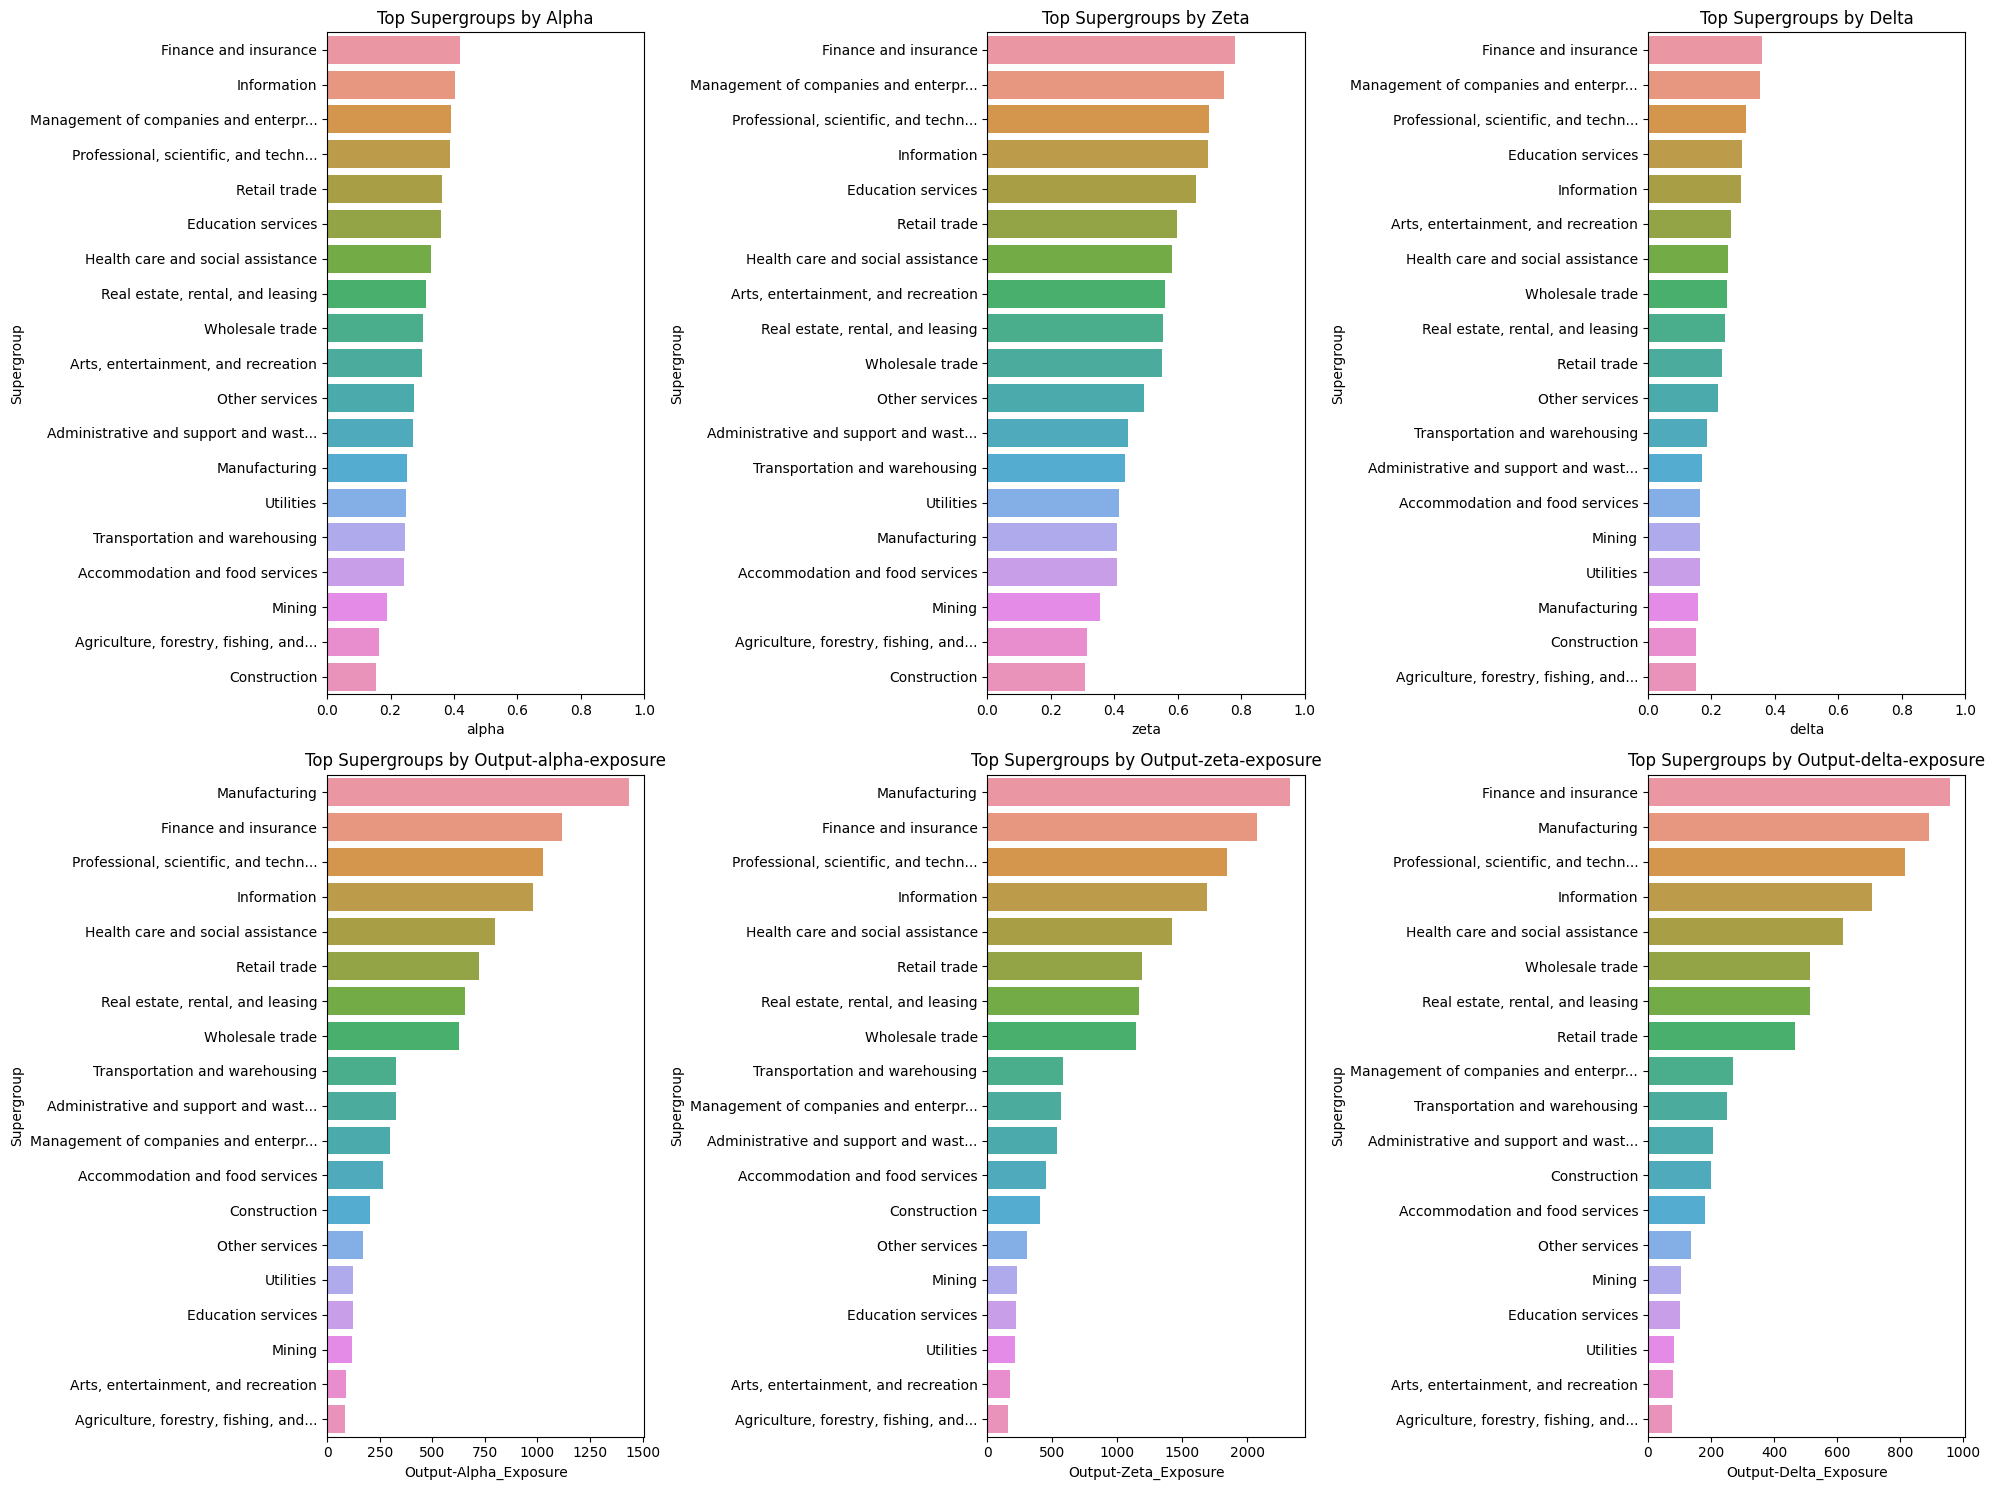

/Users/rushabh/Library/Caches/pypoetry/virtualenvs/gptsaregpts-bRn197-3-py3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/rushabh/Library/Caches/pypoetry/virtualenvs/gptsaregpts-bRn197-3-py3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/rushabh/Library/Caches/pypoetry/virtualenvs/gptsaregpts-bRn197-3-py3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/rushabh/Library/Caches/pypoetr

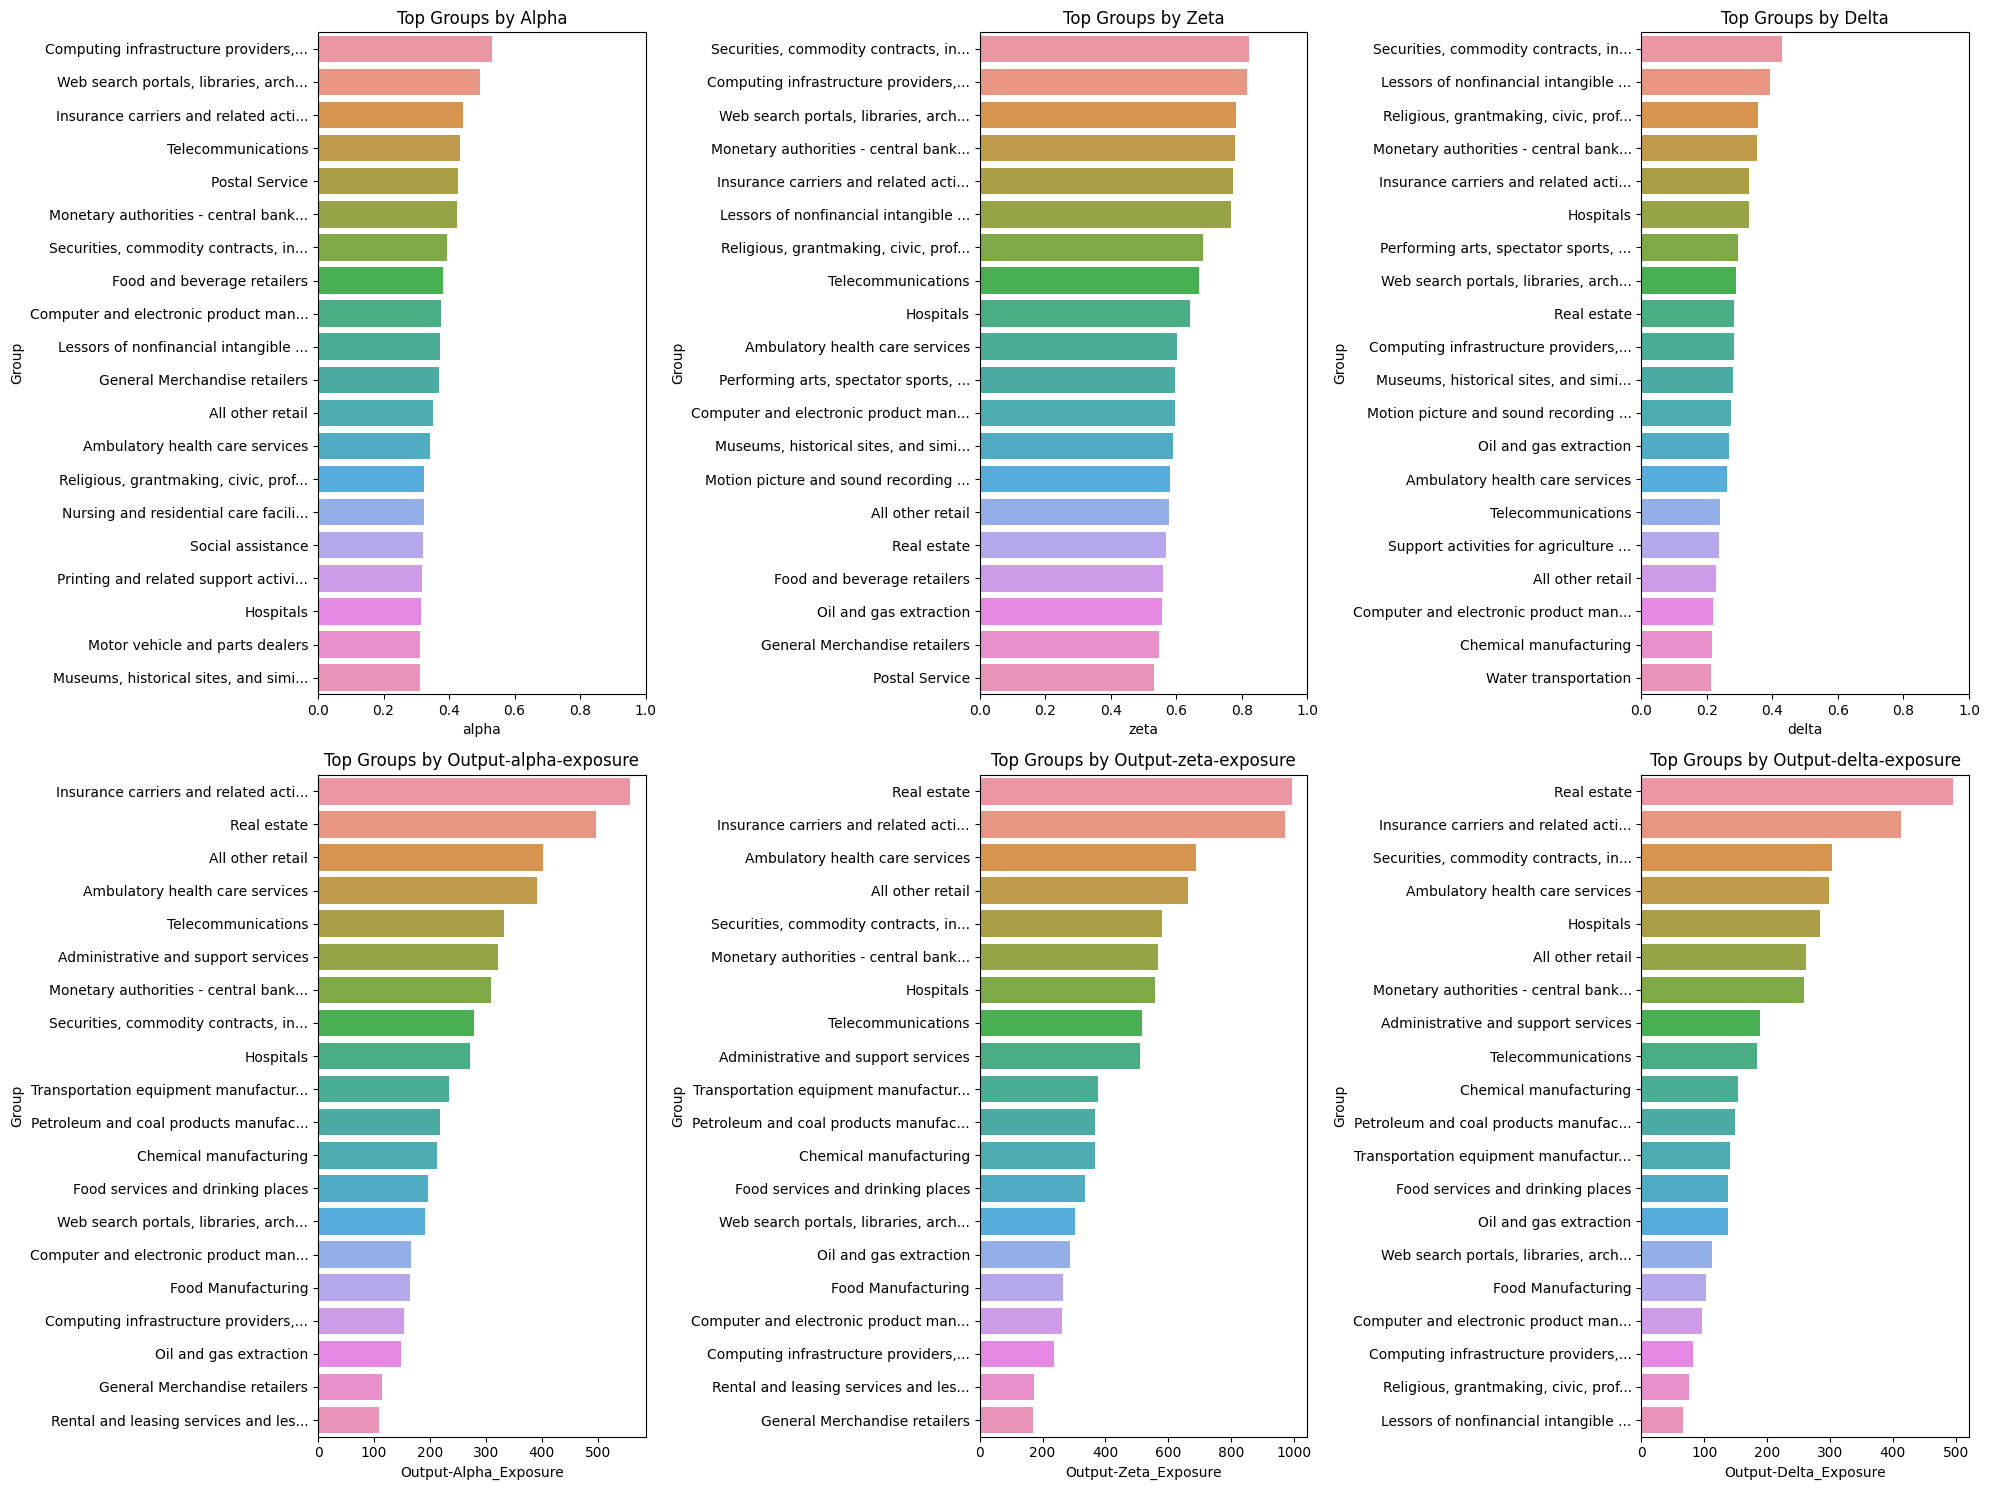

In [170]:
def plot_nlargest(df: pd.DataFrame, n: int, dimension: str):
    # Plot the supergroups by alpha, zeta, alpha_exposure, zeta_exposure
    fig, axes = plt.subplots(2, 3, figsize=(20, 15))

    dimensions = ["alpha", "zeta", "delta", "Output-Alpha_Exposure", "Output-Zeta_Exposure", "Output-Delta_Exposure"]
    dfs = [df.nlargest(n, dim) for dim in dimensions]

    for i, dim in enumerate(dimensions):
        fdim = dim.capitalize().replace("_", "-")
        sns.barplot(x=dim, y=dimension, data=dfs[i], ax=axes[i // 3][i % 3])
        axes[i // 3][i % 3].set_title(f"Top {dimension}s by {fdim}")

    # Set x-axis limits for the first two subplots only
    for ax in axes[0]:
        ax.set_xlim(0.0, 1.0)

    # Apply the ellipsize function to each axis
    for ax in axes.flatten():
        ellipsize_labels(ax)

    plt.tight_layout()
    plt.show()

    fname = dimension.lower()
    fig.savefig(OUTPUT_DATADIR / f"{fname}.png")

plot_nlargest(industry_output_clean[industry_output_clean["is_supergroup"]], 20, "Supergroup")
plot_nlargest(industry_output_clean[industry_output_clean["is_group"]], 20, "Group")


# Industry deep dive

Functions that look at a particular industry and generates CSV tables for tasks and occupations.

In [171]:
INDUSTRIES = industry_output_clean[industry_output_clean["is_supergroup"]].nlargest(10, "zeta")["Industry"].to_list()
INDUSTRIES

['Finance and insurance',
 'Management of companies and enterprises',
 'Professional, scientific, and technical services',
 'Information',
 'Education services',
 'Retail trade',
 'Health care and social assistance',
 'Arts, entertainment, and recreation',
 'Real estate, rental, and leasing',
 'Wholesale trade']

/Users/rushabh/Library/Caches/pypoetry/virtualenvs/gptsaregpts-bRn197-3-py3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/rushabh/Library/Caches/pypoetry/virtualenvs/gptsaregpts-bRn197-3-py3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/rushabh/Library/Caches/pypoetry/virtualenvs/gptsaregpts-bRn197-3-py3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/rushabh/Library/Caches/pypoetr

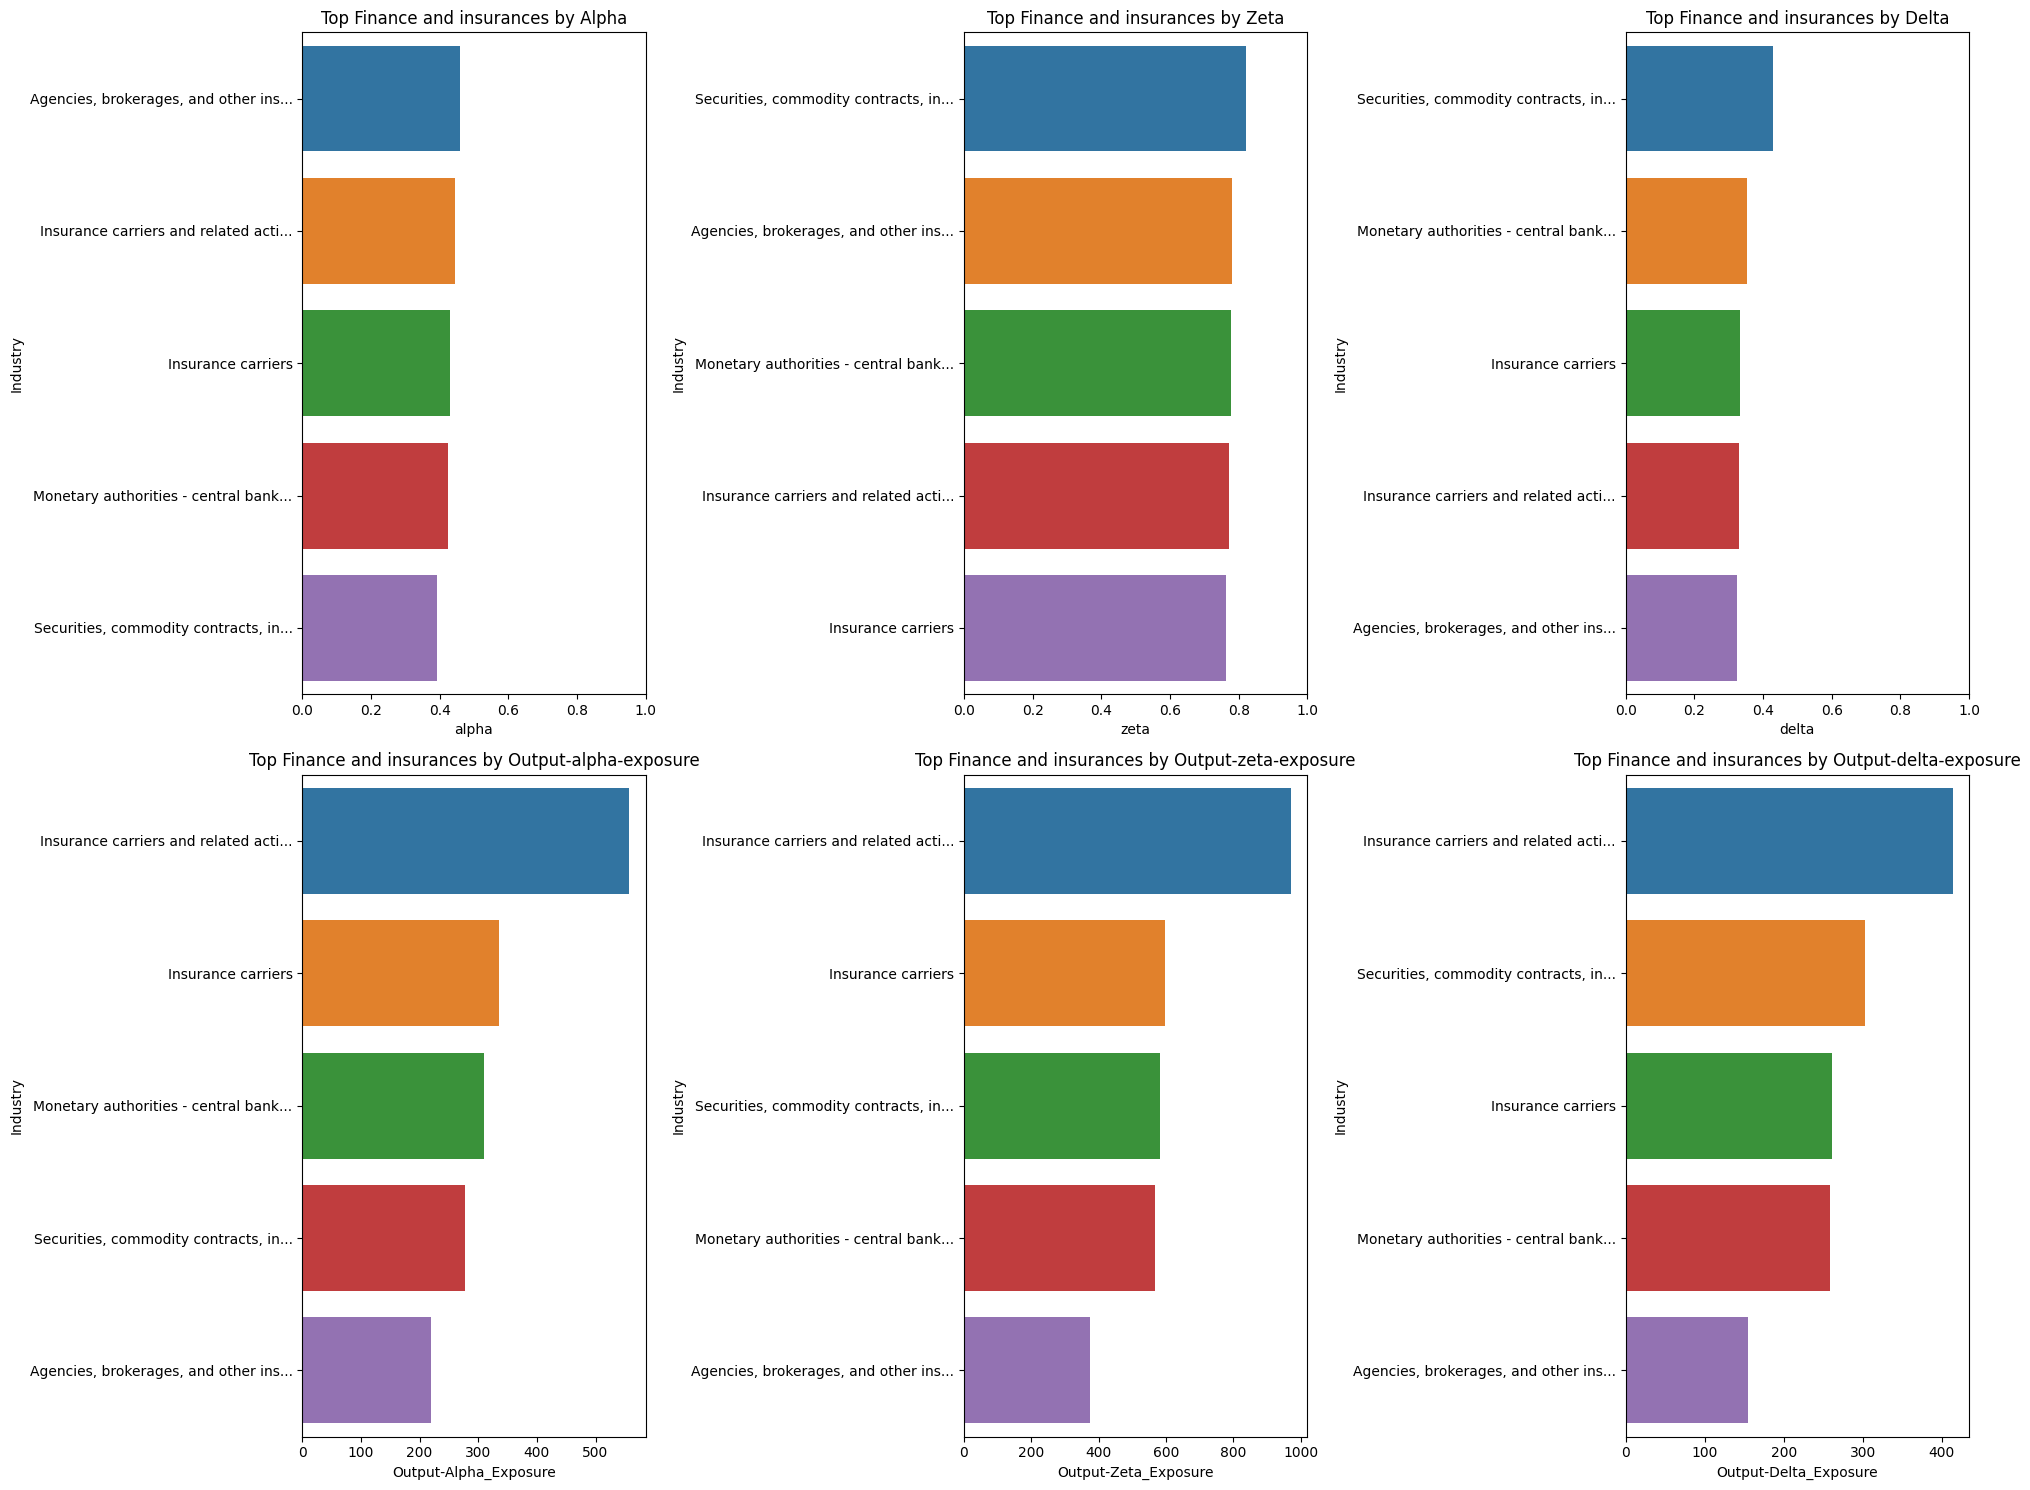

/Users/rushabh/Library/Caches/pypoetry/virtualenvs/gptsaregpts-bRn197-3-py3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/rushabh/Library/Caches/pypoetry/virtualenvs/gptsaregpts-bRn197-3-py3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/rushabh/Library/Caches/pypoetry/virtualenvs/gptsaregpts-bRn197-3-py3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/rushabh/Library/Caches/pypoetr

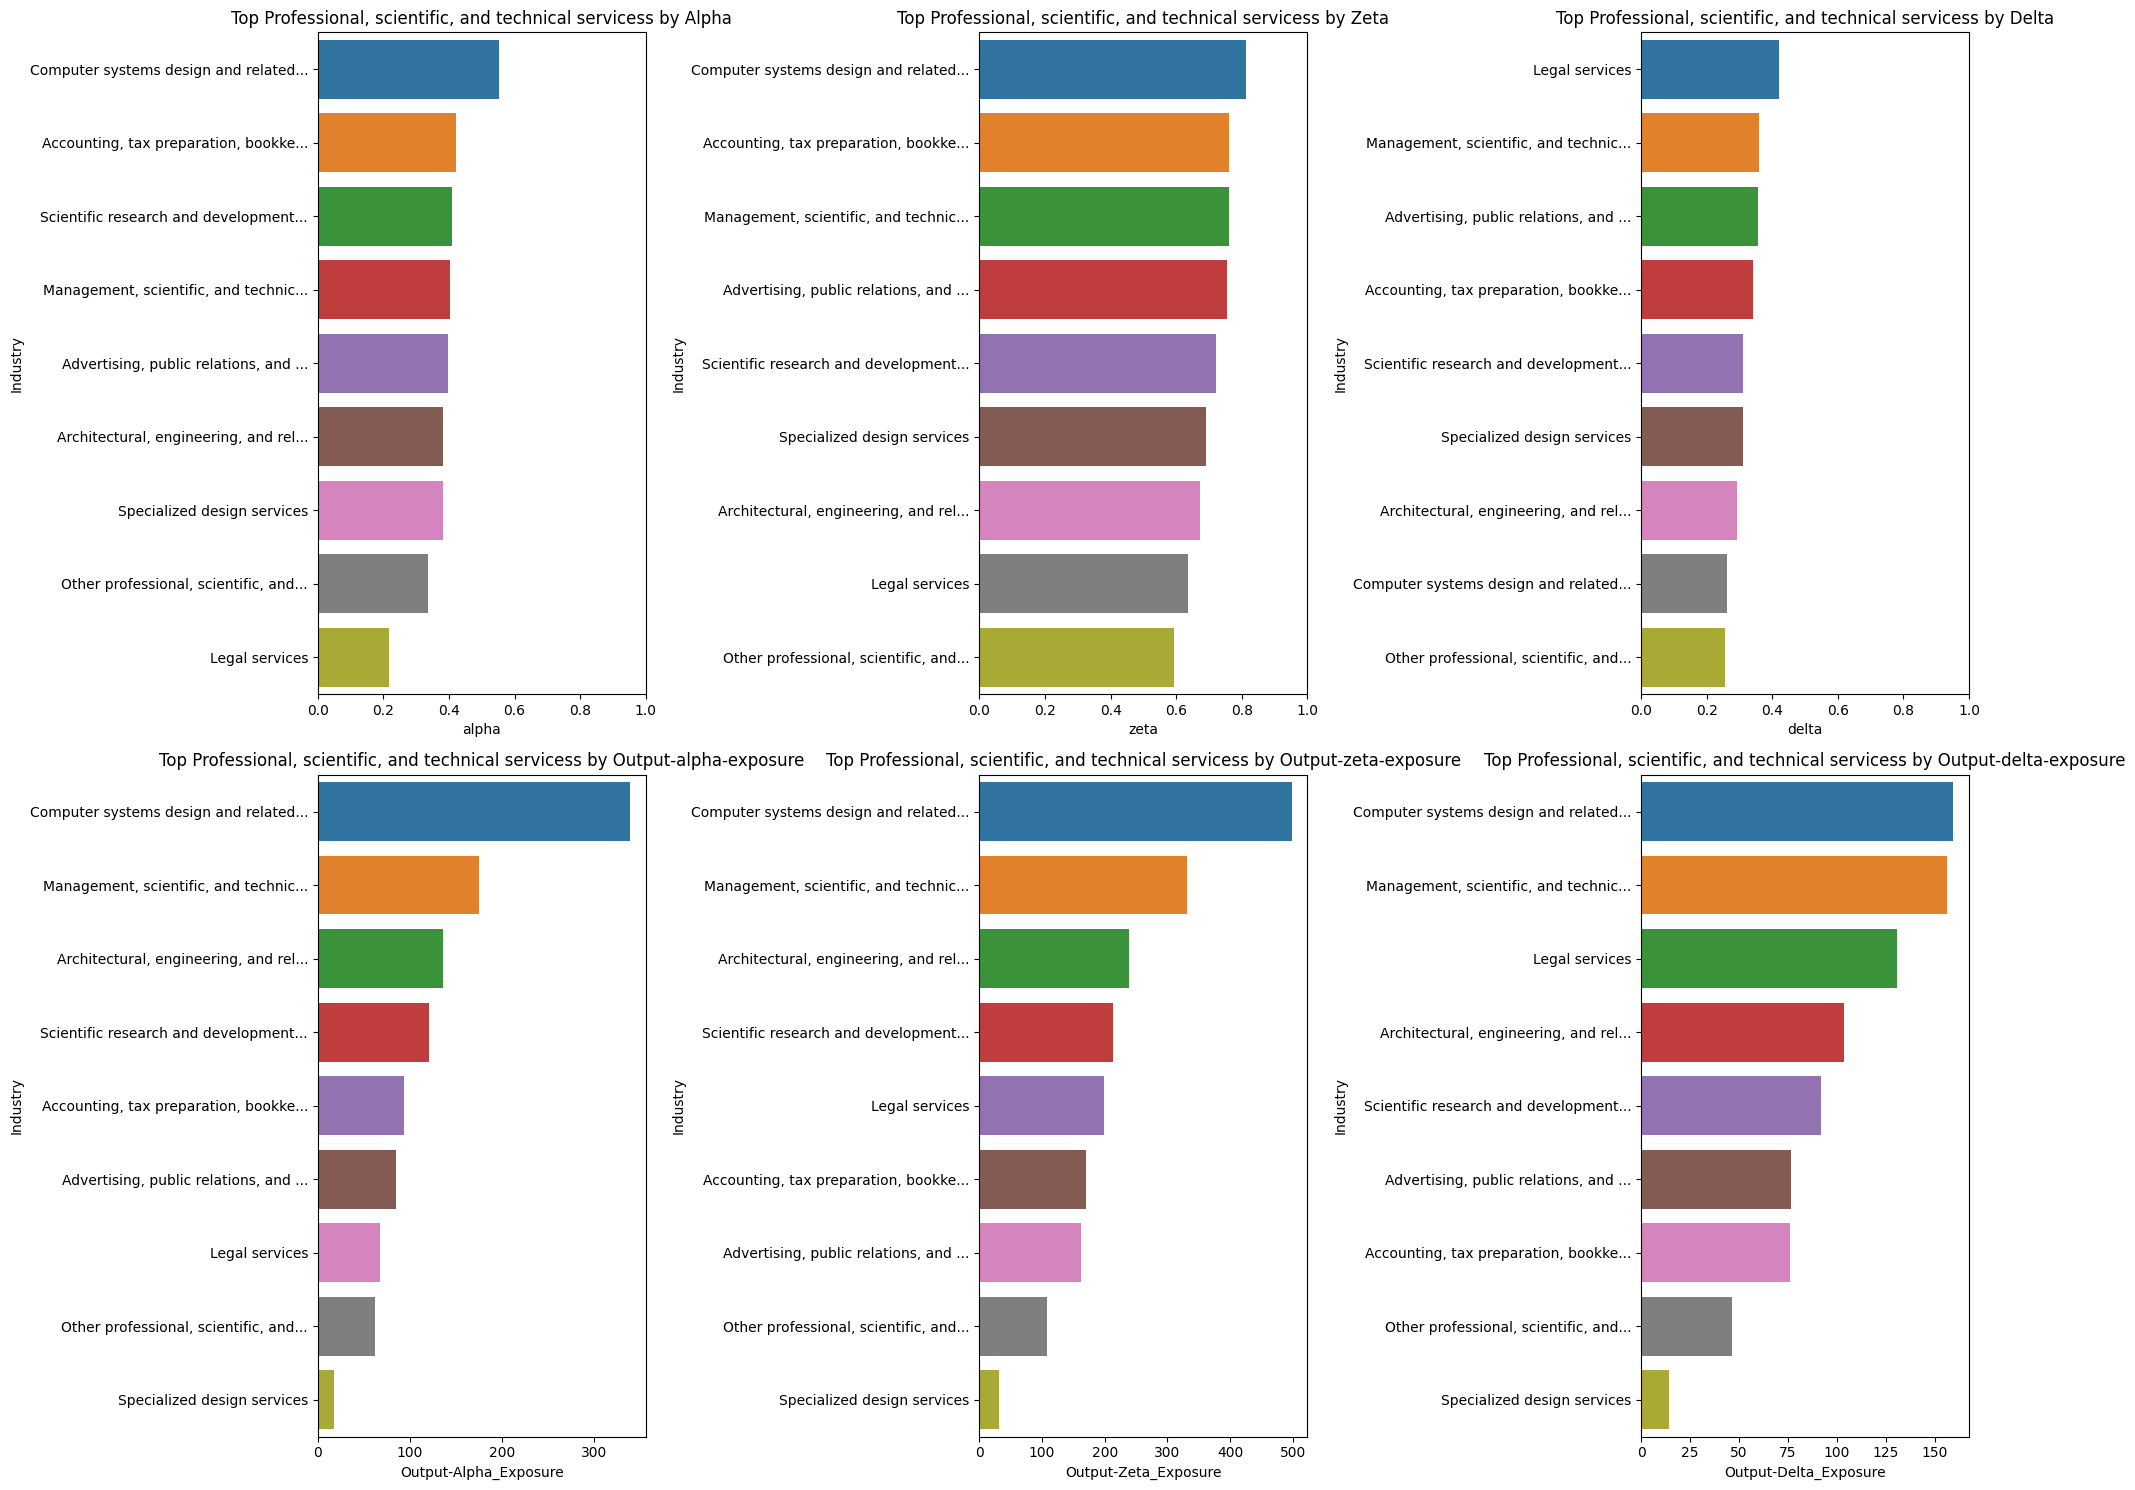

/Users/rushabh/Library/Caches/pypoetry/virtualenvs/gptsaregpts-bRn197-3-py3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/rushabh/Library/Caches/pypoetry/virtualenvs/gptsaregpts-bRn197-3-py3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/rushabh/Library/Caches/pypoetry/virtualenvs/gptsaregpts-bRn197-3-py3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/rushabh/Library/Caches/pypoetr

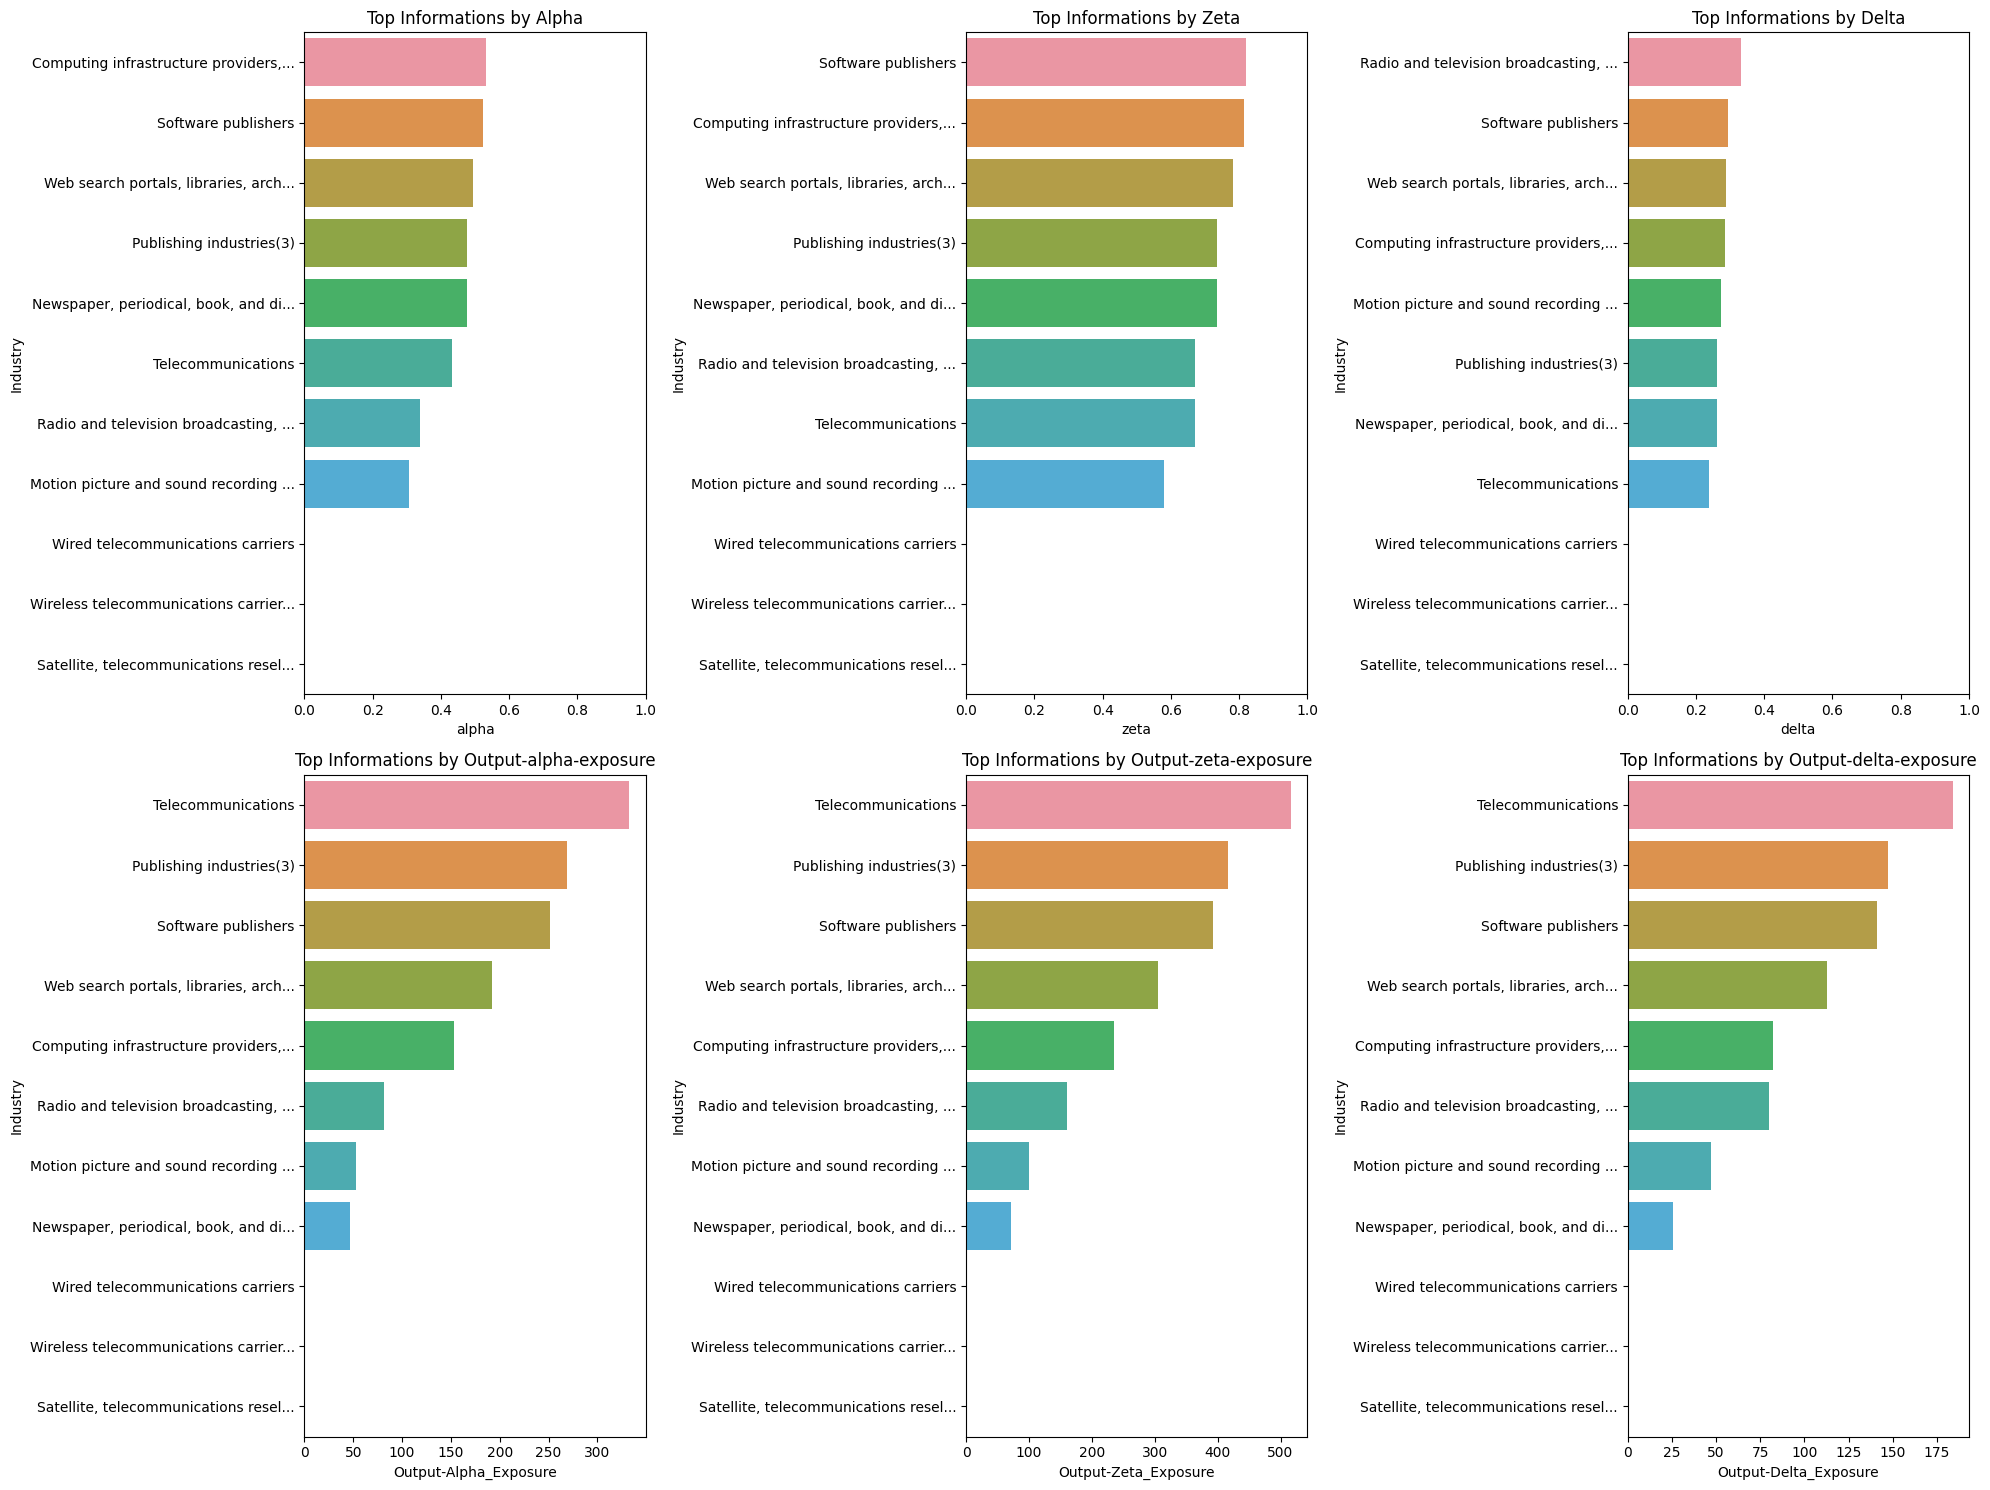

/Users/rushabh/Library/Caches/pypoetry/virtualenvs/gptsaregpts-bRn197-3-py3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/rushabh/Library/Caches/pypoetry/virtualenvs/gptsaregpts-bRn197-3-py3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/rushabh/Library/Caches/pypoetry/virtualenvs/gptsaregpts-bRn197-3-py3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/rushabh/Library/Caches/pypoetr

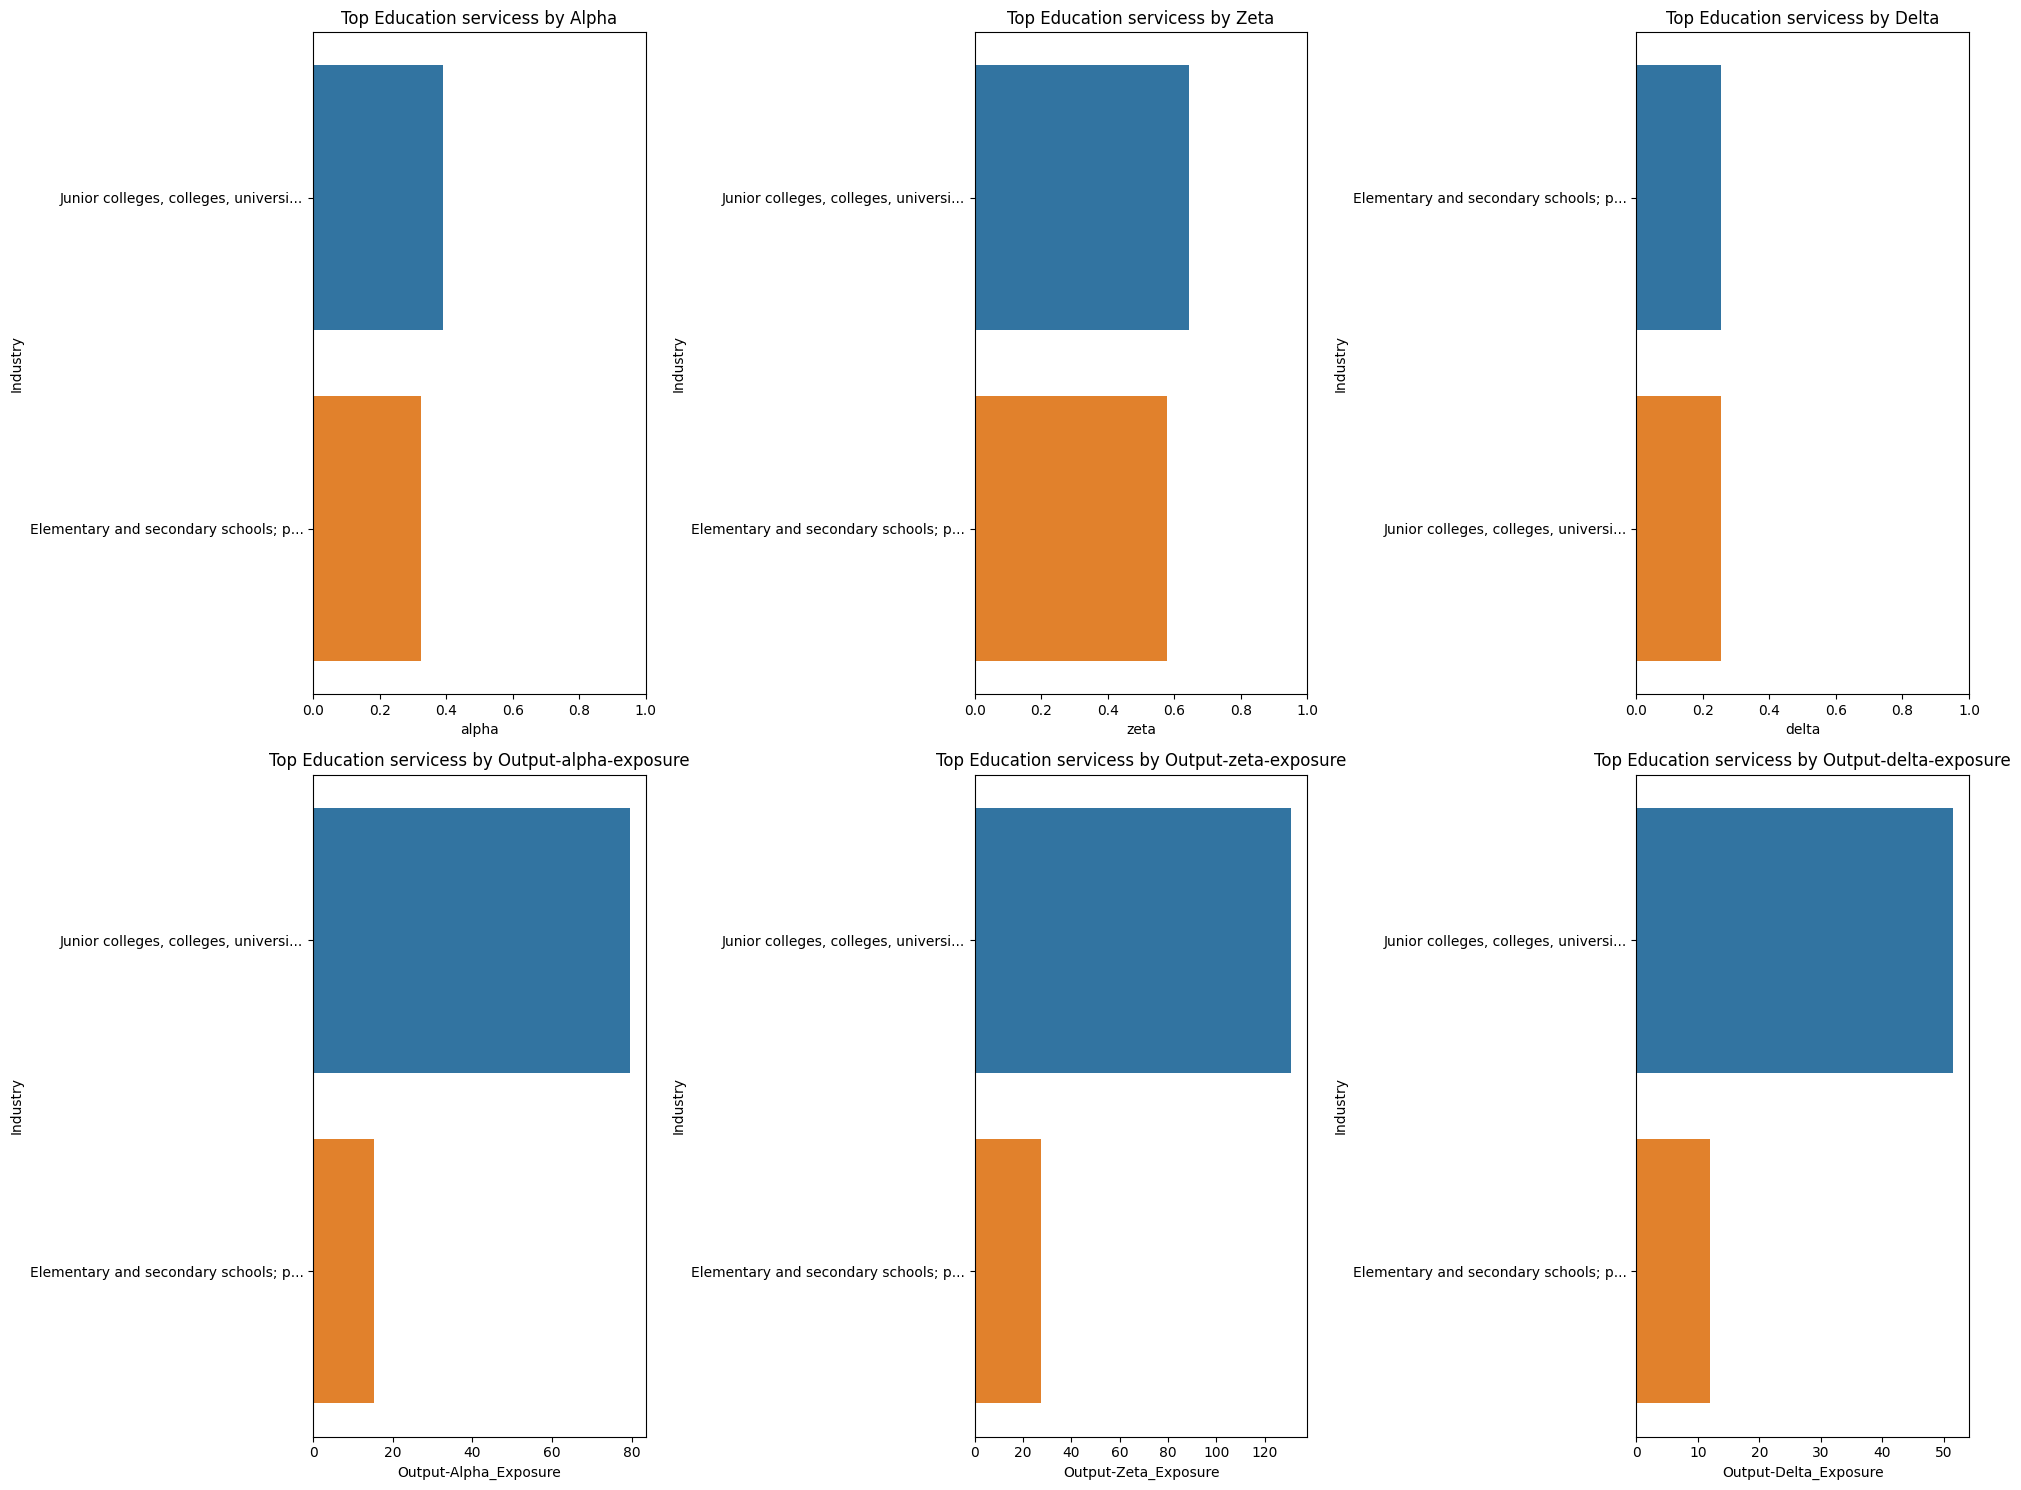

/Users/rushabh/Library/Caches/pypoetry/virtualenvs/gptsaregpts-bRn197-3-py3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/rushabh/Library/Caches/pypoetry/virtualenvs/gptsaregpts-bRn197-3-py3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/rushabh/Library/Caches/pypoetry/virtualenvs/gptsaregpts-bRn197-3-py3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/rushabh/Library/Caches/pypoetr

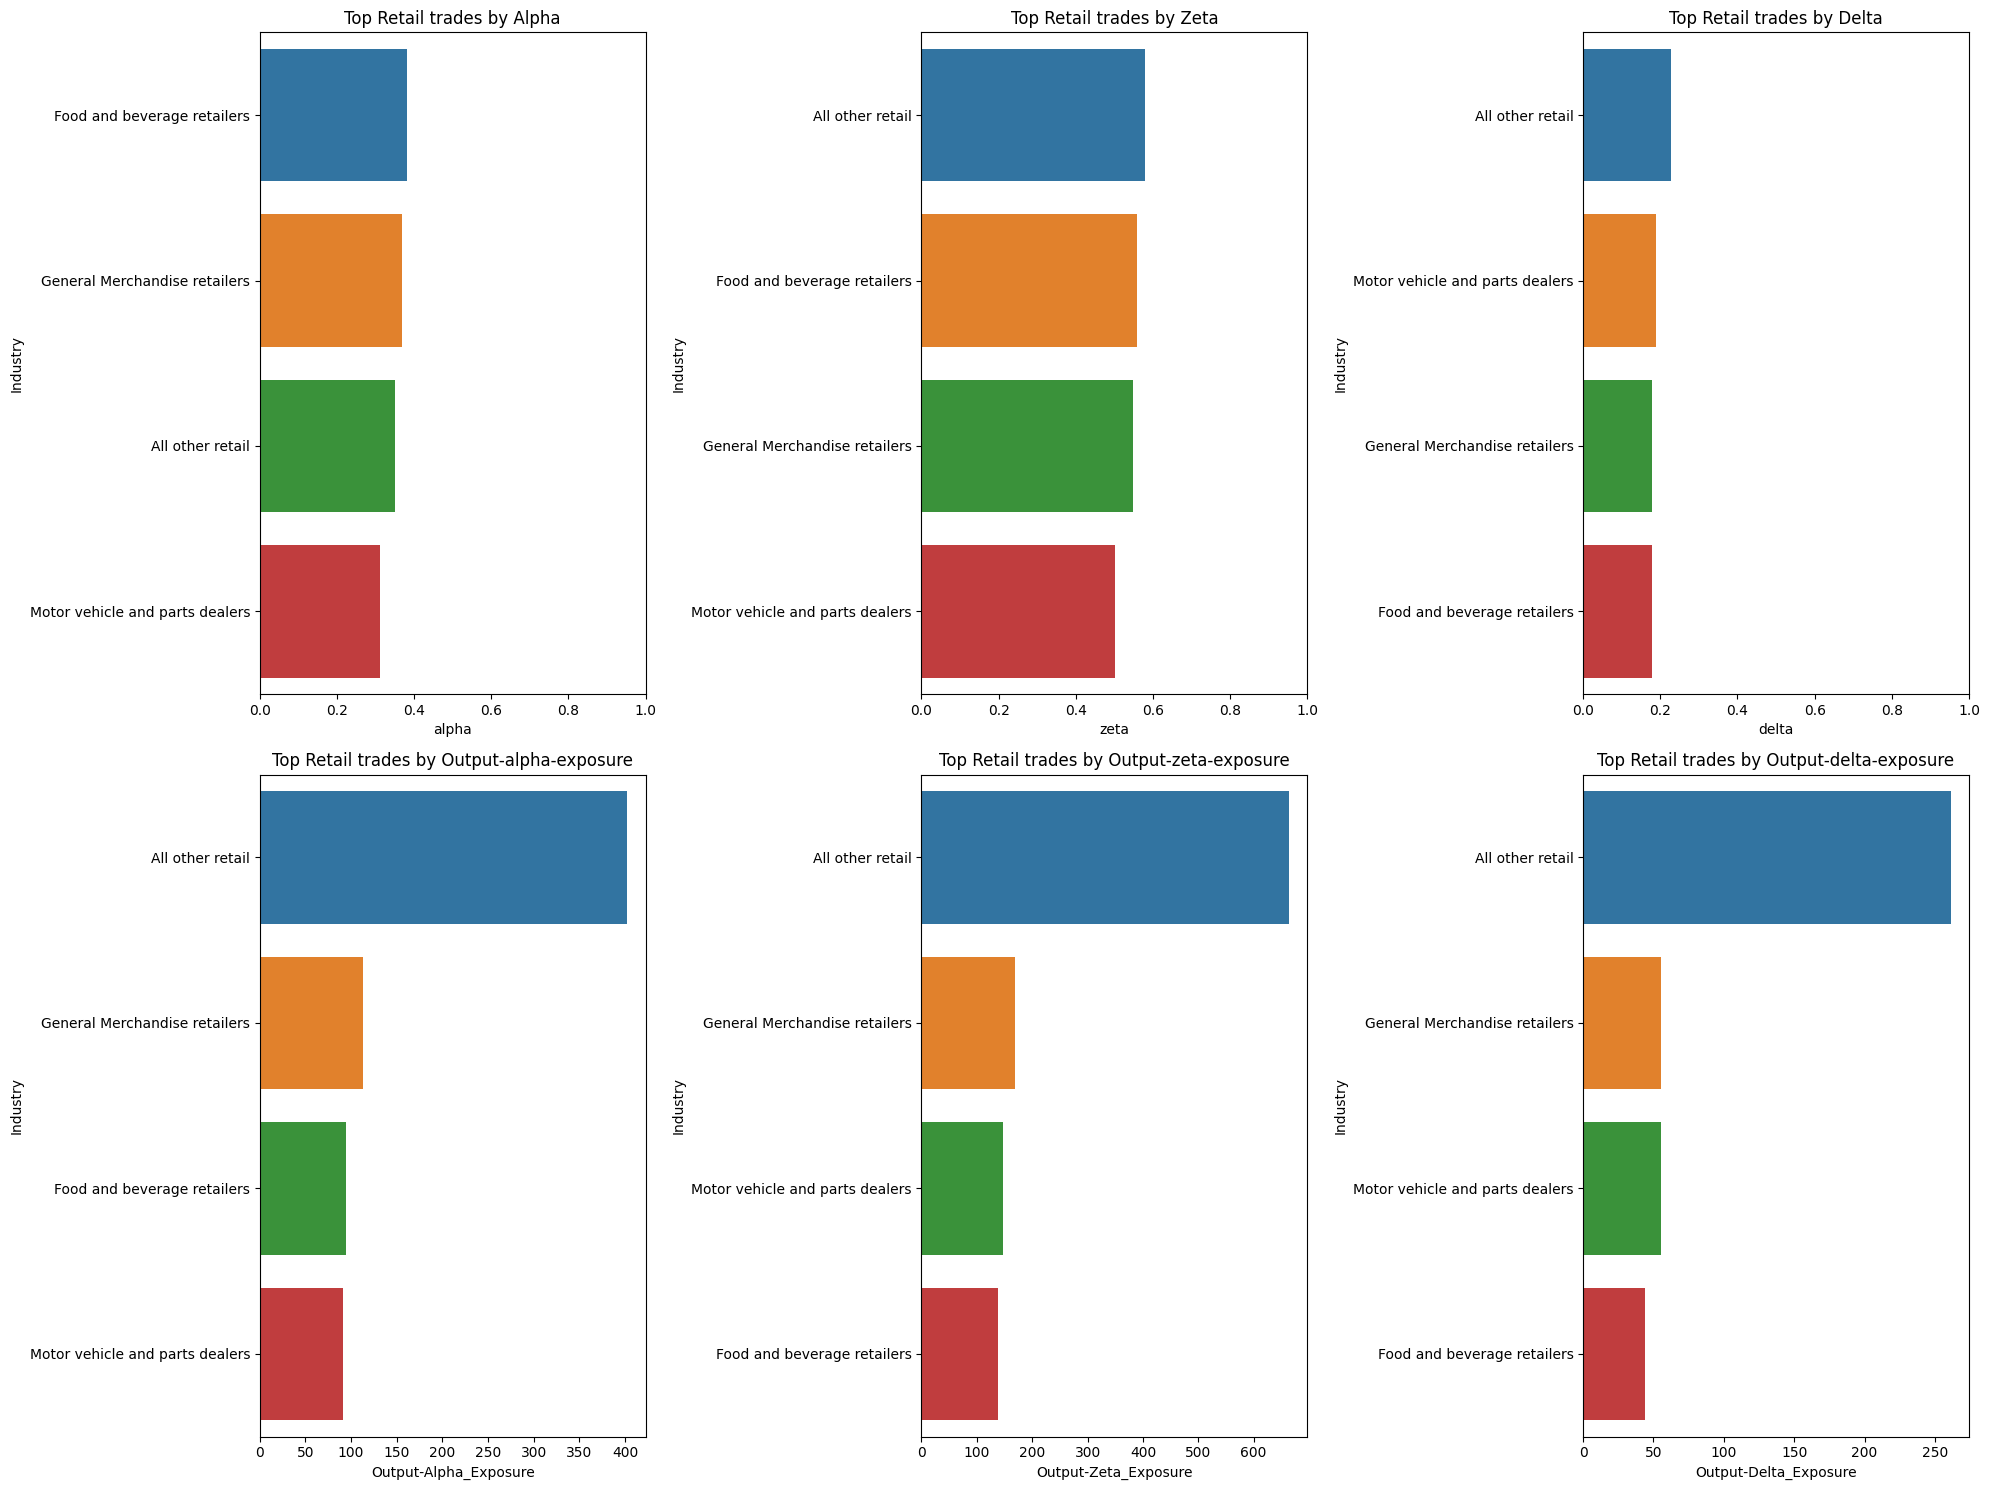

/Users/rushabh/Library/Caches/pypoetry/virtualenvs/gptsaregpts-bRn197-3-py3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/rushabh/Library/Caches/pypoetry/virtualenvs/gptsaregpts-bRn197-3-py3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/rushabh/Library/Caches/pypoetry/virtualenvs/gptsaregpts-bRn197-3-py3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/rushabh/Library/Caches/pypoetr

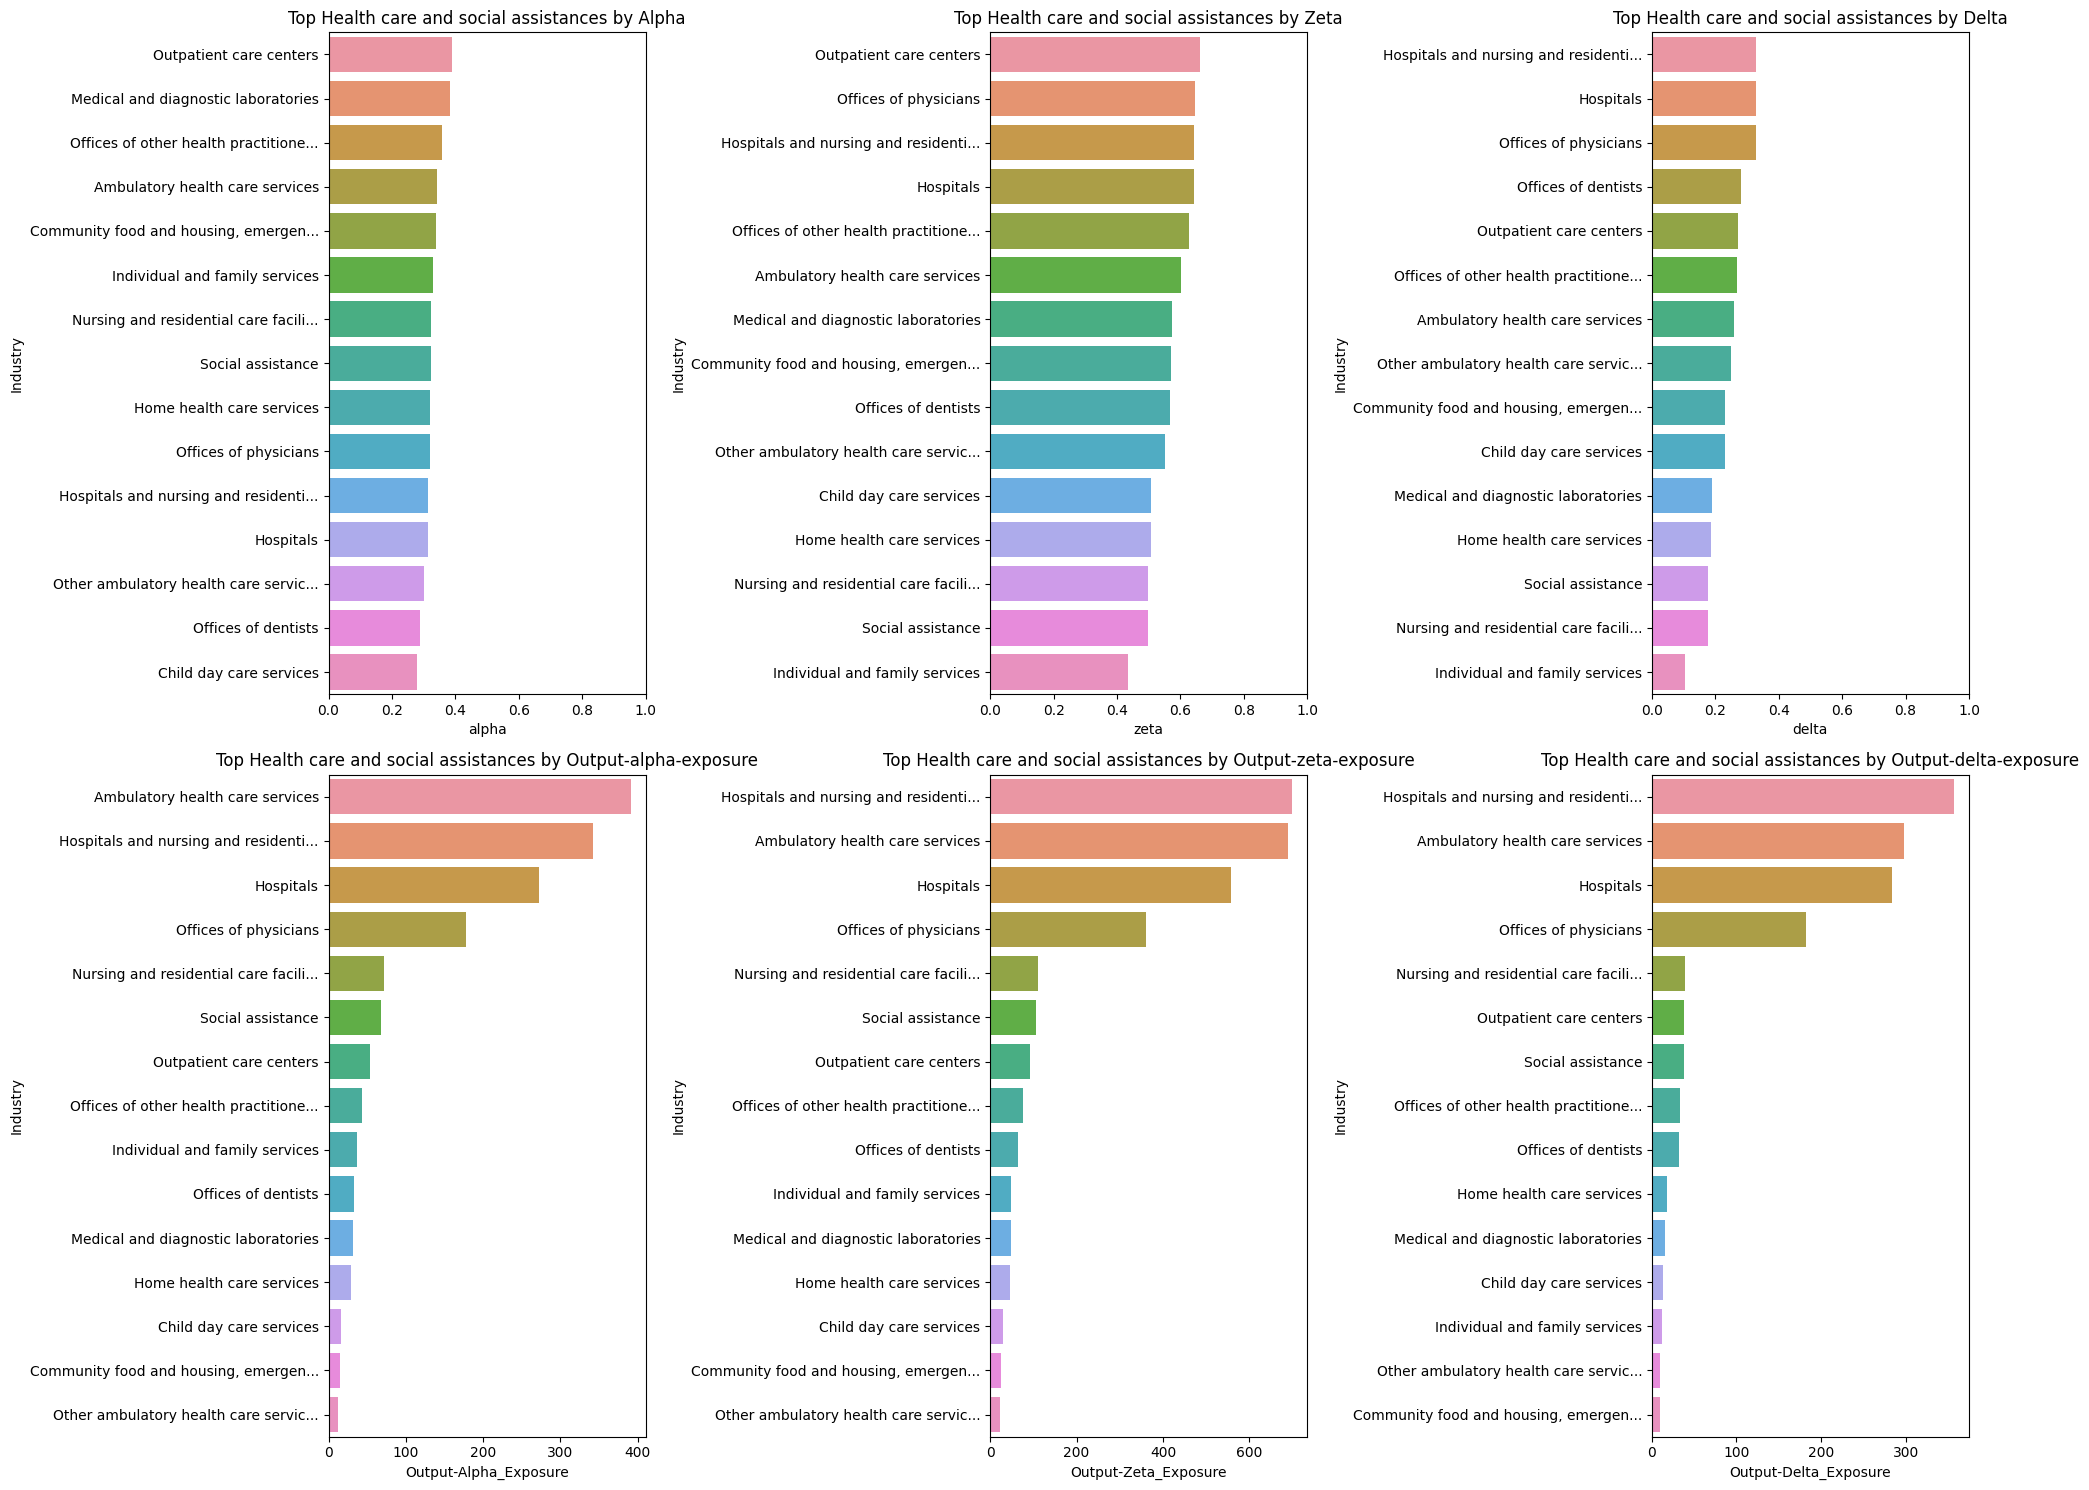

/Users/rushabh/Library/Caches/pypoetry/virtualenvs/gptsaregpts-bRn197-3-py3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/rushabh/Library/Caches/pypoetry/virtualenvs/gptsaregpts-bRn197-3-py3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/rushabh/Library/Caches/pypoetry/virtualenvs/gptsaregpts-bRn197-3-py3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/rushabh/Library/Caches/pypoetr

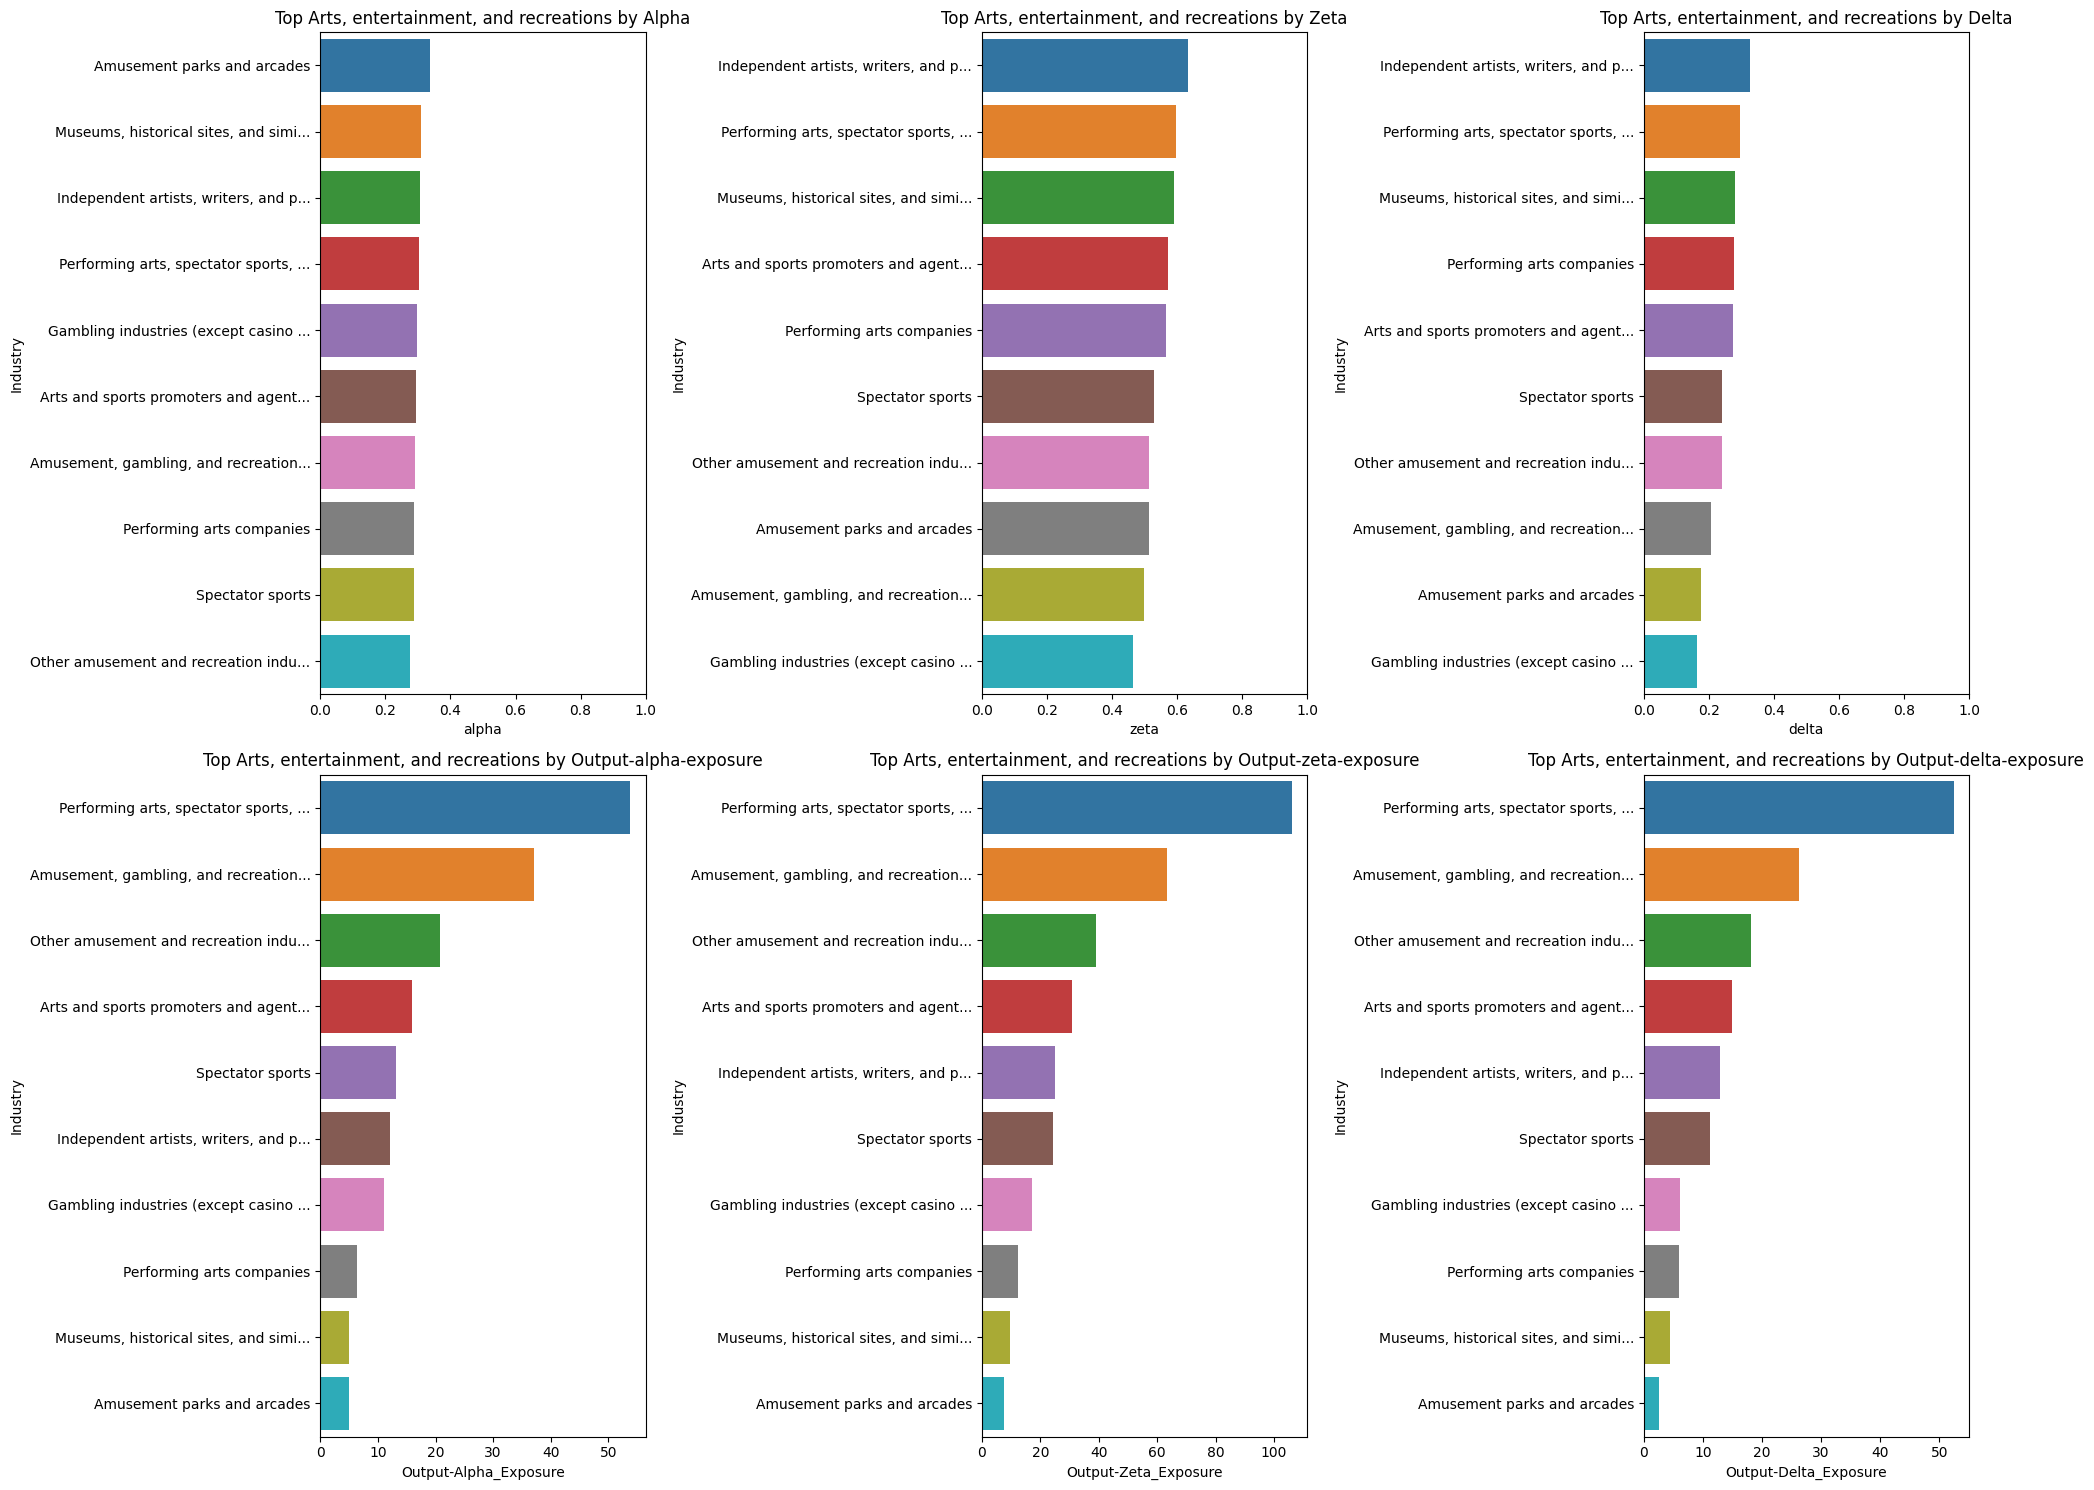

/Users/rushabh/Library/Caches/pypoetry/virtualenvs/gptsaregpts-bRn197-3-py3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/rushabh/Library/Caches/pypoetry/virtualenvs/gptsaregpts-bRn197-3-py3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/rushabh/Library/Caches/pypoetry/virtualenvs/gptsaregpts-bRn197-3-py3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/rushabh/Library/Caches/pypoetr

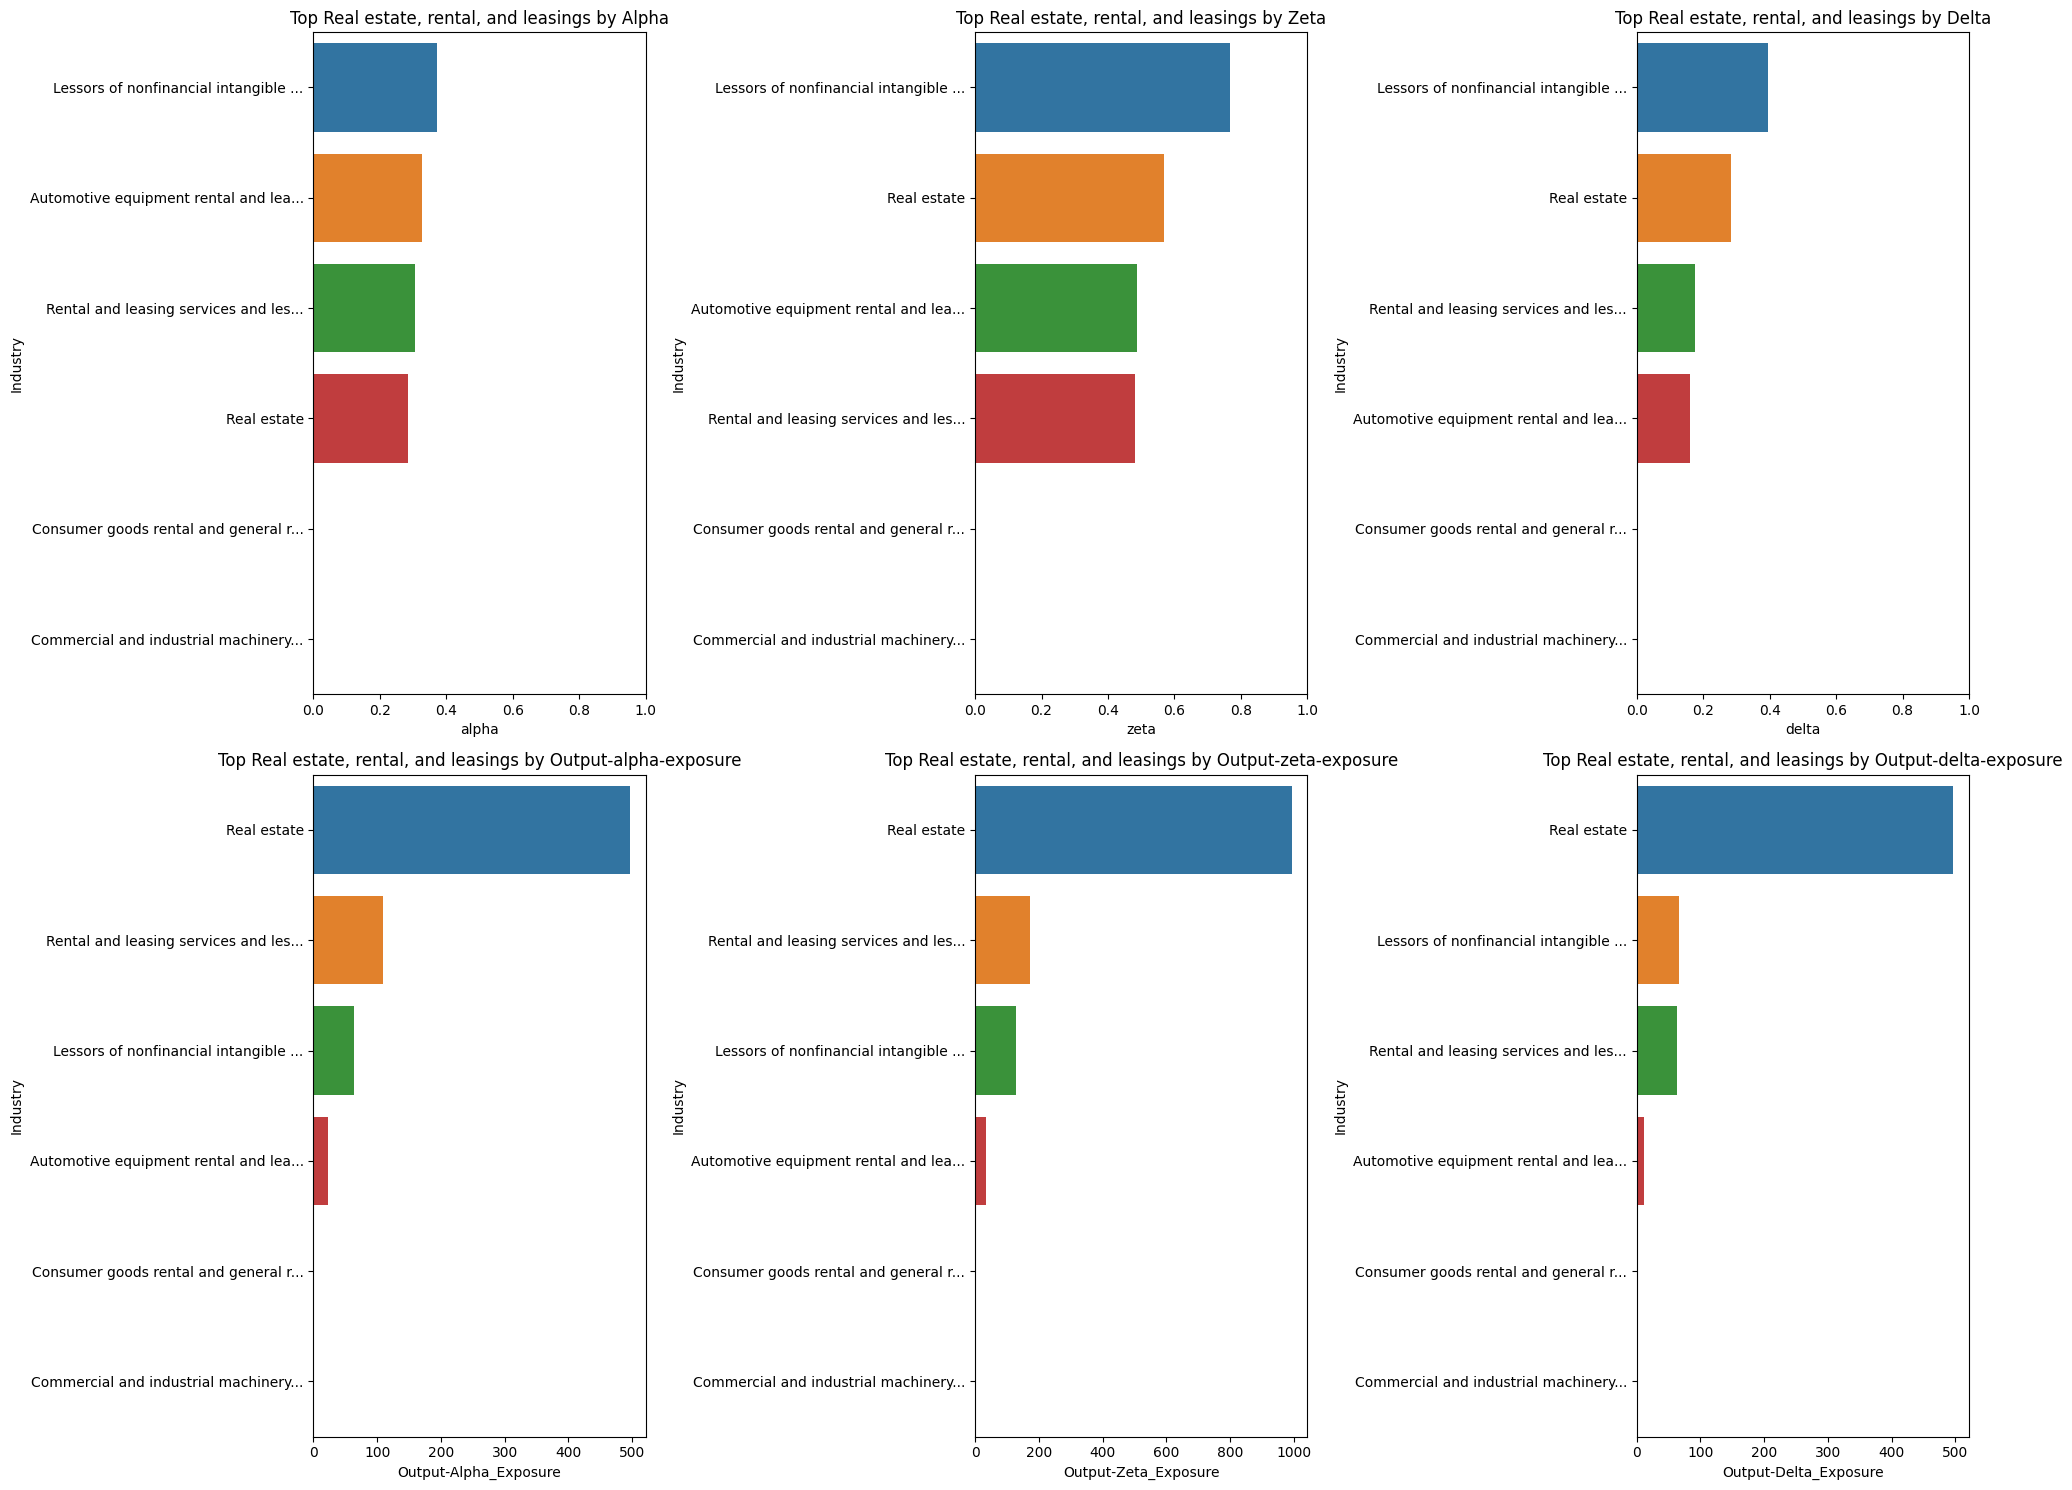

In [172]:
def plot_industry(name: str):
    industry_df = industry_output_clean[(industry_output_clean['Supergroup'] == name) & ~industry_output_clean["is_supergroup"]]

    # Drop anything if the df is empty
    if industry_df.empty:
        return

    # Plot the groups by alpha, zeta, alpha_exposure, zeta_exposure
    fig, axes = plt.subplots(2, 3, figsize=(20, 15))

    dimensions = ["alpha", "zeta", "delta", "Output-Alpha_Exposure", "Output-Zeta_Exposure", "Output-Delta_Exposure"]
    dfs = [industry_df.nlargest(20, dim) for dim in dimensions]

    for i, dim in enumerate(dimensions):
        fdim = dim.capitalize().replace("_", "-")
        sns.barplot(x=dim, y="Industry", data=dfs[i], ax=axes[i // 3][i % 3])
        axes[i // 3][i % 3].set_title(f"Top {name}s by {fdim}")

    # Set x-axis limits for the first two subplots only
    for ax in axes[0]:
        ax.set_xlim(0.0, 1.0)

    # Apply the ellipsize function to each axis
    for ax in axes.flatten():
        ellipsize_labels(ax)

    plt.tight_layout()
    plt.show()

    fname = name.lower().replace(" ", "_").replace(",", "")
    fig.savefig(OUTPUT_DATADIR / f"{fname}.png") 

for industry in INDUSTRIES:
    plot_industry(industry)

In [173]:
df = industry_output_clean[industry_output_clean["is_supergroup"]]
for dimension in ["alpha", "zeta", "delta", "Output-Delta_Exposure"]:
    print(f"Top 5 industries by {dimension}")
    print(df.nlargest(5, dimension).filter(["Industry"]).to_string(index=False))

Top 5 industries by alpha
                                        Industry
                           Finance and insurance
                                     Information
         Management of companies and enterprises
Professional, scientific, and technical services
                                    Retail trade
Top 5 industries by zeta
                                        Industry
                           Finance and insurance
         Management of companies and enterprises
Professional, scientific, and technical services
                                     Information
                              Education services
Top 5 industries by delta
                                        Industry
                           Finance and insurance
         Management of companies and enterprises
Professional, scientific, and technical services
                              Education services
                                     Information
Top 5 industries by Output-Delta_Exposure

In [174]:
def industry_occupation(industry: str, code: str):
    fname = industry.lower().replace(" ", "_").replace(",", "")
    occupation = bls_matrix_with_scores[
        (bls_matrix_with_scores["industry_code"].str.startswith(code.ljust(6, "0")))
        & (bls_matrix_with_scores["percent_industry_2022"] > 1.0)
    ].sort_values(by="percent_industry_2022", ascending=False)

    # Drop dups.
    occupation = occupation.drop_duplicates(subset=["occupation_code"], keep="first")

    # Calculate delta.
    occupation["delta"] = occupation["zeta"] - occupation["alpha"]

    # Export CSV.
    occupation.to_csv(OUTPUT_DATADIR / f"{fname}_occupation.csv", index=False)

    task_statements_updated[
        task_statements_updated["onetsoc_code"].isin(occupation["onetsoc_code"])
    ].to_csv(OUTPUT_DATADIR / f"{fname}_task_statements.csv", index=False)

    return occupation

# Working through an example flow

In [175]:
industry_output_clean[industry_output_clean["is_supergroup"] & (industry_output_clean["Industry"] == "Information")]

,Industry,2022 NAICS,"Employment, 2012","Employment, 2022","Employment, 2032","Employment change, 2012-22","Employment change, 2022-32","Employment, Compound annual rate of change, 2012-22","Employment, Compound annual rate of change, 2022-32","Output, 2012",...,zeta,delta,Supergroup,is_supergroup,Group,is_group,Output-Alpha_Exposure,Output-Beta_Exposure,Output-Zeta_Exposure,Output-Delta_Exposure
121,Information,51,"2,676.0",3074.4,"3,275.9",398.4,201.5,1.4,0.6,"1,382.5",...,0.695052,0.292342,Information,True,,False,978.021865,1333.012967,1688.004068,709.982203


In [176]:
industry_output_clean[(industry_output_clean["Supergroup"] == "Information") & (~industry_output_clean["is_supergroup"])].nlargest(10, "zeta")

,Industry,2022 NAICS,"Employment, 2012","Employment, 2022","Employment, 2032","Employment change, 2012-22","Employment change, 2022-32","Employment, Compound annual rate of change, 2012-22","Employment, Compound annual rate of change, 2022-32","Output, 2012",...,zeta,delta,Supergroup,is_supergroup,Group,is_group,Output-Alpha_Exposure,Output-Beta_Exposure,Output-Zeta_Exposure,Output-Delta_Exposure
124,Software publishers,5132,287.1,635.8,748.7,348.7,112.9,8.3,1.6,183.2,...,0.819582,0.295033,Information,False,,False,251.049481,321.650788,392.252096,141.202615
131,"Computing infrastructure providers, data proce...",518,254.9,466.3,531.7,211.4,65.4,6.2,1.3,121.9,...,0.814535,0.283581,Information,False,"Computing infrastructure providers, data proce...",True,153.711184,194.759602,235.808020,82.096837
132,"Web search portals, libraries, archives, and o...",519,95.3,189.2,225.8,93.9,36.6,7.1,1.8,99.6,...,0.782778,0.289399,Information,False,"Web search portals, libraries, archives, and o...",True,191.924707,248.212728,304.500750,112.576043
122,Publishing industries(3),"5131, 5132",766.4,940.6,"1,024.3",174.2,83.7,2.1,0.9,296.2,...,0.735974,0.260556,Information,False,,False,269.134242,342.884643,416.635045,147.500803
123,"Newspaper, periodical, book, and directory pub...",5131,479.3,304.8,275.6,-174.5,-29.2,-4.4,-1.0,113.0,...,0.735974,0.260556,Information,False,,False,46.353274,59.055384,71.757493,25.404219
126,"Radio and television broadcasting, media strea...","5161, 5162",340.3,356.5,359.3,16.2,2.8,0.5,0.1,153.9,...,0.670914,0.331933,Information,False,,False,81.423172,121.288347,161.153522,79.730350
127,Telecommunications,517,856.8,663.1,649.4,-193.7,-13.7,-2.5,-0.2,579.2,...,0.670813,0.238716,Information,False,Telecommunications,True,332.843765,424.785371,516.726977,183.883212
125,Motion picture and sound recording industries,512,362.3,458.7,485.3,96.4,26.6,2.4,0.6,131.7,...,0.580634,0.273832,Information,False,Motion picture and sound recording industries,True,52.647274,76.142064,99.636854,46.989579
128,Wired telecommunications carriers,517111,589.5,475.1,475.3,-114.4,0.2,-2.1,0.0,310.7,...,NaN,NaN,Information,False,Telecommunications,False,NaN,NaN,NaN,NaN
129,Wireless telecommunications carriers (except s...,517112,156.8,93.0,93.7,-63.8,0.7,-5.1,0.1,230.5,...,NaN,NaN,Information,False,Telecommunications,False,NaN,NaN,NaN,NaN


In [177]:
bls_matrix_cleaned[bls_matrix_cleaned["industry_code"].str.startswith("5132")].nlargest(10, "employment_2022")["occupation_title"].to_list()

['Software developers',
 'Computer and information systems managers',
 'Computer user support specialists',
 'Sales representatives, wholesale and manufacturing, technical and scientific products',
 'Sales representatives, wholesale and manufacturing, technical and scientific products',
 'Sales representatives of services, except advertising, insurance, financial services, and travel',
 'Market research analysts and marketing specialists',
 'Market research analysts and marketing specialists',
 'General and operations managers',
 'Customer service representatives']

In [178]:
task_statements_updated[task_statements_updated["onetsoc_code"] == "15-1252.00"]["task"].to_list()

['Analyze information to determine, recommend, and plan installation of a new system or modification of an existing system.',
 'Analyze user needs and software requirements to determine feasibility of design within time and cost constraints.',
 'Confer with data processing or project managers to obtain information on limitations or capabilities for data processing projects.',
 'Confer with systems analysts, engineers, programmers and others to design systems and to obtain information on project limitations and capabilities, performance requirements and interfaces.',
 'Consult with customers or other departments on project status, proposals, or technical issues, such as software system design or maintenance.',
 'Coordinate installation of software system.',
 'Design, develop and modify software systems, using scientific analysis and mathematical models to predict and measure outcomes and consequences of design.',
 'Determine system performance standards.',
 'Develop or direct software s

In [179]:
tasks_to_dwas[tasks_to_dwas["task_id"] == 21669]

,onetsoc_code,task_id,dwa_id
3194,15-1252.00,21669,4.A.2.b.4.I03.D15
3195,15-1252.00,21669,4.A.4.b.4.I06.D07


In [180]:
dwa_reference[dwa_reference["dwa_id"].isin(["4.A.2.b.4.I03.D15", "4.A.4.b.4.I06.D07"])]["dwa_title"].to_list()

['Develop testing routines or procedures.',
 'Manage information technology projects or system activities.']

FIN